In [ ]:
import numpy as np
import re

from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr
from matplotlib.colors import LinearSegmentedColormap, SymLogNorm
from matplotlib.gridspec import GridSpec

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [23]:
#Get a list of all species names
species_list = ['alligator_mississippiensis', 'anolis_carolinensis', 'anopheles_gambiae', 'apis_mellifera', 'arabidopsis_thaliana', 'aspergillus_nidulans', 'bos_taurus', 'brachypodium_distachyon', 'caenorhabditis_elegans', 'canis_lupus_familiaris', 'columba_livia', 'coprinopsis_cinerea', 'cryptococcus_neoformans', 'danio_rerio', 'daphnia_carinata', 'dictyostelium_discoideum', 'drosophila_melanogaster', 'eimeria_maxima', 'entamoeba_histolytica', 'equus_caballus', 'gallus_gallus', 'giardia_intestinalis', 'glycine_max', 'gorilla_gorilla', 'homo_sapiens', 'hordeum_vulgare', 'leishmania_donovani', 'lotus_japonicus', 'manduca_sexta', 'medicago_truncatula', 'mus_musculus', 'neurospora_crassa', 'nicotiana_tabacum', 'oreochromis_niloticus', 'oryctolagus_cuniculus', 'oryza_sativa', 'oryzias_latipes', 'ovis_aries', 'pan_troglodytes', 'phoenix_dactylifera', 'plasmodium_falciparum', 'rattus_norvegicus', 'rhizophagus_irregularis', 'saccharomyces_cerevisiae', 'schizophyllum_commune', 'schizosaccharomyces_pombe', 'selaginella_moellendorffii', 'setaria_viridis', 'solanum_lycopersicum', 'strongylocentrotus_purpuratus', 'sus_scrofa', 'taeniopygia_guttata', 'toxoplasma_gondii', 'tribolium_castaneum', 'trichoplax_adhaerens', 'triticum_aestivum', 'trypanosoma_brucei', 'ustilago_maydis', 'xenopus_laevis', 'zea_mays']

protozoa_list = ['plasmodium_falciparum', 'entamoeba_histolytica', 'dictyostelium_discoideum',
                 'giardia_intestinalis', 'trypanosoma_brucei', 'leishmania_donovani', 
                 'toxoplasma_gondii', 'eimeria_maxima']

fungi_list = ['saccharomyces_cerevisiae', 'ustilago_maydis', 'schizosaccharomyces_pombe',
              'aspergillus_nidulans', 'cryptococcus_neoformans', 'neurospora_crassa', 
              'coprinopsis_cinerea', 'rhizophagus_irregularis', 'schizophyllum_commune']

plants_list = ['oryza_sativa', 'arabidopsis_thaliana', 'selaginella_moellendorffii', "brachypodium_distachyon", 
               "setaria_viridis", "zea_mays", "hordeum_vulgare", 
               "triticum_aestivum", "phoenix_dactylifera", "lotus_japonicus",
               "medicago_truncatula", "nicotiana_tabacum", "glycine_max", "solanum_lycopersicum"]

invertebrates_list = ['trichoplax_adhaerens', 'tribolium_castaneum', 'manduca_sexta', 
                      'apis_mellifera', 'strongylocentrotus_purpuratus', 'daphnia_carinata', 
                      'drosophila_melanogaster', 'anopheles_gambiae', 'caenorhabditis_elegans']

vertebrates_list = ['gallus_gallus', 'alligator_mississippiensis', 'xenopus_laevis',
                    'oreochromis_niloticus', 'homo_sapiens', 'bos_taurus', "mus_musculus", "ovis_aries", "canis_lupus_familiaris", 
                    "equus_caballus", "gorilla_gorilla", "pan_troglodytes",
                    "rattus_norvegicus", "oryctolagus_cuniculus", "sus_scrofa",
                    "danio_rerio", "oryzias_latipes", "taeniopygia_guttata",
                    "columba_livia", "anolis_carolinensis"]

In [24]:
def extract_similar_sequences(species, threshold):
    """ 
    Extract sequence numbers of sequences homologous to TIS Transformer training data. 
    """
    similar_sequences = []
    with open(f"../../data/data_evaluation/TIS_transformer/similar_sequences/similar_sequences_{species}.txt", "r") as infile:
        for line in infile:
            if float(line.split("|")[1].strip()) > threshold:
                similar_sequences.append(line.split("|")[0])

    return similar_sequences

## Load in saved, processed predictions

In [25]:
# Load the DataFrames from the CSV files
augustus_df_full = pd.read_csv('../../data/data_evaluation/preds_processed/testset/augustus_df.csv.gz')
augustus_genomic_df = pd.read_csv('../../data/data_evaluation/preds_processed/genes/augustus_genomic_df.csv.gz')

tiberius_df_full = pd.read_csv('../../data/data_evaluation/preds_processed/testset/tiberius_df.csv.gz')
tiberius_genomic_df = pd.read_csv('../../data/data_evaluation/preds_processed/genes/tiberius_genomic_df.csv.gz')

TIS_transformer_df_full = pd.read_csv('../../data/data_evaluation/preds_processed/testset/TIS_transformer_df.csv.gz')
TIS_transformer_genomic_df = pd.read_csv('../../data/data_evaluation/preds_processed/genes/TIS_transformer_genomic_df.csv.gz')

netstart_overall_df_full = pd.read_csv('../../data/data_evaluation/preds_processed/testset/netstart_overall_df.csv.gz')
netstart_genomic_overall_df = pd.read_csv('../../data/data_evaluation/preds_processed/genes/netstart_genomic_overall_df.csv.gz')

netstart_group_df_full = pd.read_csv('../../data/data_evaluation/preds_processed/testset/netstart_group_df.csv.gz')
netstart_genomic_group_df = pd.read_csv('../../data/data_evaluation/preds_processed/genes/netstart_genomic_group_df.csv.gz')

esm2_finetuned_df_full = pd.read_csv('../../data/data_evaluation/preds_processed/testset/esm2_finetuned_df.csv.gz')
esm2_finetuned_genomic_df = pd.read_csv('../../data/data_evaluation/preds_processed/genes/esm2_finetuned_genomic_df.csv.gz')

netstart1_df_full = pd.read_csv('../../data/data_evaluation/preds_processed/testset/netstart1_df.csv.gz')
netstart1_genomic_df = pd.read_csv('../../data/data_evaluation/preds_processed/genes/netstart1_genomic_df.csv.gz')

# Remove intron and intergenic sequences from test set

In [26]:
TIS_transformer_df = TIS_transformer_df_full[~TIS_transformer_df_full["seq_type"].isin(["Intron", "Intergenic"])]
netstart_overall_df = netstart_overall_df_full[~netstart_overall_df_full["seq_type"].isin(["Intron", "Intergenic"])]
netstart_group_df = netstart_group_df_full[~netstart_group_df_full["seq_type"].isin(["Intron", "Intergenic"])]
esm2_finetuned_df = esm2_finetuned_df_full[~esm2_finetuned_df_full["seq_type"].isin(["Intron", "Intergenic"])]
netstart1_df = netstart1_df_full[~netstart1_df_full["seq_type"].isin(["Intron", "Intergenic"])]
augustus_df = augustus_df_full[~augustus_df_full["seq_type"].isin(["Intron", "Intergenic"])]
tiberius_df = tiberius_df_full[~tiberius_df_full["seq_type"].isin(["Intron", "Intergenic"])]

## Ensure correct data loading for all models

In [27]:
assert TIS_transformer_df.shape[0] == netstart_overall_df.shape[0] == netstart_group_df.shape[0]  == netstart1_df.shape[0] == esm2_finetuned_df.shape[0]
assert netstart_overall_df[netstart_overall_df["species"] == "homo_sapiens"].shape[0] == tiberius_df[tiberius_df["species"] == "homo_sapiens"].shape[0]
assert netstart_overall_df[netstart_overall_df["species"] == "arabidopsis_thaliana"].shape[0] == tiberius_df[tiberius_df["species"] == "arabidopsis_thaliana"].shape[0]

# Benchmark on Test Partition

## Remove homologous sequences
Remove sequences with high homology between TIS Transformer training set and homology partitioned test set.

In [28]:
def abbreviate_species_name(species_name):
    # Regex to match genus_species and abbreviate to G. species
    return re.sub(r'(\w+?)_(\w+)', lambda m: f"{m.group(1)[0].upper()}. {m.group(2)}", species_name)


TIS_transformer_df_placeholder = pd.DataFrame()
augustus_df_placeholder = pd.DataFrame()
tiberius_df_placeholder = pd.DataFrame()
netstart_overall_df_placeholder = pd.DataFrame()
netstart_group_df_placeholder = pd.DataFrame()
esm2_finetuned_df_placeholder = pd.DataFrame()
netstart1_df_placeholder = pd.DataFrame()

for species in species_list:
    similar_sequences_species = extract_similar_sequences(species, 50)
    all_sequences_species = TIS_transformer_df[(TIS_transformer_df["species"] == species) & (TIS_transformer_df["label"] == 1.0)]

    species_name_formatted = abbreviate_species_name(species)
    
    #LaTeX table entries for supplementary materials
    #print("\\"+"textit{" + species_name_formatted + "} & " + str(len(similar_sequences_species)) + " & " + str(round(len(similar_sequences_species)/len(all_sequences_species) * 100, 3)) + "\\\\")

    #Get non-homologous species data
    TIS_transformer_df_species = TIS_transformer_df[(TIS_transformer_df["species"] == species) & (~TIS_transformer_df["seq_number"].isin(similar_sequences_species))]
    augustus_df_species = augustus_df[(augustus_df["species"] == species) & (~augustus_df["seq_number"].isin(similar_sequences_species))]
    tiberius_df_species = tiberius_df[(tiberius_df["species"] == species) & (~tiberius_df["seq_number"].isin(similar_sequences_species))]
    netstart_overall_df_species = netstart_overall_df[(netstart_overall_df["species"] == species) & (~netstart_overall_df["seq_number"].isin(similar_sequences_species))]
    netstart_group_df_species = netstart_group_df[(netstart_group_df["species"] == species) & (~netstart_group_df["seq_number"].isin(similar_sequences_species))]
    esm2_finetuned_df_species = esm2_finetuned_df[(esm2_finetuned_df["species"] == species) & (~esm2_finetuned_df["seq_number"].isin(similar_sequences_species))]
    netstart1_df_species = netstart1_df[(netstart1_df["species"] == species) & (~netstart1_df["seq_number"].isin(similar_sequences_species))]

    #Add to dataframe
    TIS_transformer_df_placeholder = pd.concat([TIS_transformer_df_placeholder, TIS_transformer_df_species])
    augustus_df_placeholder = pd.concat([augustus_df_placeholder, augustus_df_species])
    tiberius_df_placeholder = pd.concat([tiberius_df_placeholder, tiberius_df_species])
    netstart_overall_df_placeholder = pd.concat([netstart_overall_df_placeholder, netstart_overall_df_species])
    netstart_group_df_placeholder = pd.concat([netstart_group_df_placeholder, netstart_group_df_species])
    esm2_finetuned_df_placeholder = pd.concat([esm2_finetuned_df_placeholder, esm2_finetuned_df_species])
    netstart1_df_placeholder = pd.concat([netstart1_df_placeholder, netstart1_df_species])


TIS_transformer_df = TIS_transformer_df_placeholder
augustus_df = augustus_df_placeholder
tiberius_df = tiberius_df_placeholder
netstart_overall_df = netstart_overall_df_placeholder
netstart_group_df = netstart_group_df_placeholder
esm2_finetuned_df = esm2_finetuned_df_placeholder
netstart1_df = netstart1_df_placeholder


# Benchmark analyses

In [29]:
def calculate_ROC_species(pred_df, species_list, save_plot, group_title, colors):
    """
    Plot ROC curves and calculate AUROC for all species.
    """
    
    plt.figure(figsize=(8,8))

    i = 0
    
    for species in species_list:
        species_lowercase = species.lower().replace(" ", "_")
        
        information_df_species = pred_df[pred_df["species"] == species_lowercase]

        roc_auc = roc_auc_score(information_df_species["label"], information_df_species["preds"])
        fpr, tpr, _ = roc_curve(information_df_species["label"], information_df_species["preds"])
        
        #Plot ROC curve
        plt.plot(fpr, tpr, color = colors[i], lw=2, label=f'{species}: {roc_auc:.4f}')
        
        i += 1
    
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(group_title, fontsize=18)
    plt.legend(loc="lower right", fontsize = 12)
    plt.savefig("../../results/evaluation/netstart2_performance/"+save_plot+".png")
    #plt.show()

In [30]:
def calculate_PR_species(pred_df, species_list, save_plot, group_title, colors):
    """
    Plot PR curves and calculate AUPRC for all species.
    """
    
    plt.figure(figsize=(8,8))

    i = 0
    
    for species in species_list:
        species_lowercase = species.lower().replace(" ", "_")
        
        information_df_species = pred_df[pred_df["species"] == species_lowercase]

        #print("Number of observations: ", len(information_df_species["species"]))
        pr_auc = average_precision_score(information_df_species["label"], information_df_species["preds"])
        precision, recall, _ = precision_recall_curve(information_df_species["label"], information_df_species["preds"])
        
        #Plot ROC curve
        plt.plot(recall, precision, color = colors[i], lw=2, label=f'{species}: {pr_auc:.4f}')
        
        i += 1
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(group_title, fontsize=18)
    plt.legend(loc="lower left", fontsize = 12)
    plt.savefig("../../results/evaluation/netstart2_performance/"+save_plot+".png")
    #plt.show()

In [31]:
#For ROC curves (Highest AUROC -> lowest AUROC)
fungi_list_upper = ['Saccharomyces cerevisiae', 'Schizosaccharomyces pombe', 'Cryptococcus neoformans', 'Ustilago maydis', 'Aspergillus nidulans', 'Neurospora crassa', 'Coprinopsis cinerea', 'Schizophyllum commune', 'Rhizophagus irregularis']

protozoa_list_upper = ['Plasmodium falciparum', 'Trypanosoma brucei', 'Giardia intestinalis', 'Entamoeba histolytica', 'Dictyostelium discoideum', 'Toxoplasma gondii', 'Leishmania donovani', 'Eimeria maxima']

plants_list_upper = ['Oryza sativa',  "Hordeum vulgare", "Phoenix dactylifera", "Brachypodium distachyon", "Glycine max",  "Solanum lycopersicum", "Zea mays", "Triticum aestivum", "Medicago truncatula", 'Arabidopsis thaliana', "Lotus japonicus", 
                     "Setaria viridis", "Nicotiana tabacum", 'Selaginella moellendorffii']

invertebrates_list_upper = ['Apis mellifera', 'Tribolium castaneum',  'Manduca sexta', 'Daphnia carinata', 'Drosophila melanogaster', 'Strongylocentrotus purpuratus', 'Trichoplax adhaerens', 'Anopheles gambiae', 'Caenorhabditis elegans']

vertebrates_list_upper = ["Oryzias latipes", 'Gallus gallus', "Rattus norvegicus",  "Anolis carolinensis", "Equus caballus", "Mus musculus", "Danio rerio", "Ovis aries", 'Xenopus laevis', 'Alligator mississippiensis', 'Bos taurus',
                          'Oreochromis niloticus', "Sus scrofa", "Taeniopygia guttata",  "Canis lupus familiaris", 'Homo sapiens', "Oryctolagus cuniculus", "Gorilla gorilla", "Columba livia", "Pan troglodytes"]

def plot_aucs_group(group_list, group):
    #Make curves with overall model
    calculate_ROC_species(pred_df = netstart_overall_df, species_list = group_list, save_plot = f"auroc_{group}", group_title = f"AUROC in {group} species", colors = sns.color_palette("Spectral", len(group_list)))
    calculate_PR_species(pred_df = netstart_overall_df, species_list = group_list, save_plot =  f"aupr_{group}", group_title = f"AUPR in {group} species", colors = sns.color_palette("Spectral", len(group_list)))

#plot_aucs_group(protozoa_list_upper, "protozoan")
#plot_aucs_group(fungi_list_upper, "fungal")
#plot_aucs_group(plants_list_upper, "plant")
#plot_aucs_group(vertebrates_list_upper, "vertebrate")
#plot_aucs_group(invertebrates_list_upper, "invertebrate")

In [32]:
def get_output_distribution(pred_df, ylim, title, save_plot):
    """
    Plot output distribution of predicted probabilities for TIS- and non-TIS-labelled sequences. 
    """
    #Extract only testset (meaning that we exclude predictions from the 25 species not used in model development)

    TIS_preds = pred_df[pred_df["seq_type"] == "TIS"]
    non_TIS_preds = pred_df[pred_df["label"] == 0.0]

    plt.figure(figsize=(7, 5))

    plt.hist(non_TIS_preds["preds"], bins=100, alpha=1, color="#66C2A5", label="Non-TIS")
    plt.hist(TIS_preds["preds"], bins=50, alpha=0.5, color="#1B0A8F", label="TIS")
    plt.legend(loc="upper right", fontsize = 10)
    plt.ylim([0, ylim])
    plt.xlim([0,1])
    plt.title(title, fontsize = 16)
    plt.xlabel('TIS Probability', fontsize=14)
    plt.savefig("../../results/evaluation/benchmark/"+save_plot)
    #plt.show()

def get_output_distribution_species(species, ylim):
    get_output_distribution(netstart_overall_df[netstart_overall_df["species"] == species], ylim, "Distribution of Predicted TIS Probability \n NetStart 2.0 (" + species + ")", "distribution_netstart_"+species+".png")
    get_output_distribution(TIS_transformer_df[TIS_transformer_df["species"] == species], ylim, "Distribution of Predicted TIS Probability \n TIS Transformer (" + species + ")", "distribution_tis_transformer_"+species+".png")
    

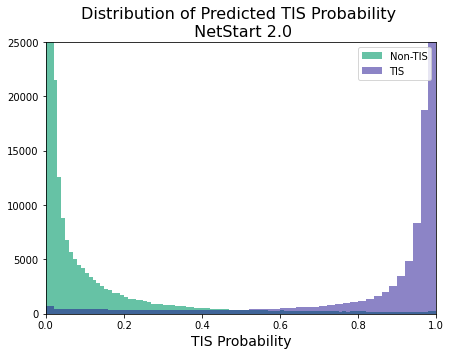

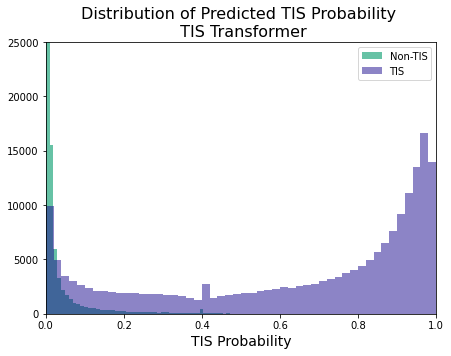

In [33]:
#Plot distributions for different groups and overall
get_output_distribution(netstart_overall_df, 25000, "Distribution of Predicted TIS Probability \n NetStart 2.0", "distribution_netstart.png") ## non-tis: 1.02e6, tis: 132000
get_output_distribution(TIS_transformer_df, 25000, "Distribution of Predicted TIS Probability \n TIS Transformer", "distribution_tis_transformer.png") ## non-tis: 1.17e6, tis: kan ses

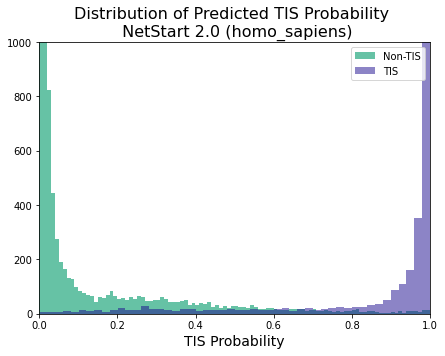

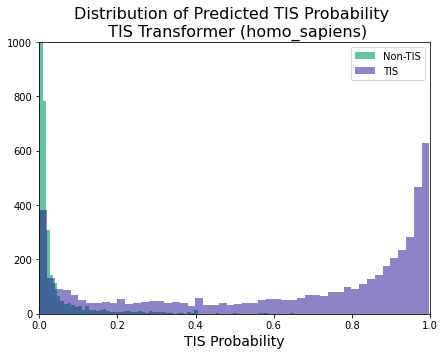

In [34]:
get_output_distribution_species("homo_sapiens", 1000)
#netstart non-TIS: 72000, TIS: approx 3500 same for both models
#TIS transformer non-TIS: 77000

In [35]:
def calculate_error_rates(pred_df, species_list, model):
    """
    Plot threshold-dependent metrics as a function of threshold and calculate 
    error rates on the various sequence types for all specified species based on MCC-optimized threshold.
    """
    def __calculate_error_rates__(information_df, best_threshold):
        """
        Calculate sequence type-specific error rates based on specified threshold. 
        """
        ####Calculate error rates on the different sequence types####

        #Calculating error rate based on the best found threshold for the different classes of sequences
        up_in_data = information_df[information_df["seq_type"] == "Upstream, in frame"]
        up_out_data = information_df[information_df["seq_type"] == "Upstream, out of frame"]
        down_in_data = information_df[information_df["seq_type"] == "Downstream, in frame"]
        down_out_data = information_df[information_df["seq_type"] == "Downstream, out of frame"]
        tis_data = information_df[information_df["seq_type"] == "TIS"]

        error_rate_total = round(np.mean(np.array(information_df["label"]) != (np.array(information_df["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_up_in = round(np.mean(np.array(up_in_data["label"]) != (np.array(up_in_data["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_up_out = round(np.mean(np.array(up_out_data["label"]) != (np.array(up_out_data["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_down_in = round(np.mean(np.array(down_in_data["label"]) != (np.array(down_in_data["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_down_out = round(np.mean(np.array(down_out_data["label"]) != (np.array(down_out_data["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_TIS = round(np.mean(np.array(tis_data["label"]) != (np.array(tis_data["preds"]) >= best_threshold).astype(int)) * 100, 2)

        return error_rate_total, error_rate_up_in, error_rate_up_out, error_rate_down_in, error_rate_down_out, error_rate_TIS
    
    #Find global MCC-optimized threshold based on testset (partition 5)
    thresholds = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55,
                  0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1] 
    
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6', '#e67e22', '#1abc9c', '#34495e']

    
    #initialize
    mccs = []
    tpr = []
    fpr = []
    precision = []
    f1s = []
    
    for threshold in thresholds:
        cm = confusion_matrix(np.array(pred_df["label"]), (np.array(pred_df["preds"]) >= threshold).astype(int))
        tn, fp, fn, tp = cm.ravel()
        current_tpr = tp / (tp + fn)
        current_fpr = fp / (fp + tn)
        current_precision = tp / (tp + fp)

        # Append TPR for the current threshold
        tpr.append(current_tpr)
        fpr.append(current_fpr)
        precision.append(current_precision)
        mccs.append(matthews_corrcoef(np.array(pred_df["label"]), (np.array(pred_df["preds"]) >= threshold).astype(int))) 
        f1s.append(f1_score(np.array(pred_df["label"]), (np.array(pred_df["preds"]) >= threshold).astype(int))) 

    best_threshold, best_mcc, best_tpr, best_fpr, best_precision, best_f1 = max(zip(thresholds, mccs, tpr, fpr, precision, f1s), key=lambda x: x[1])
    
    pr_auc = average_precision_score(pred_df["label"], pred_df["preds"])
    roc_auc = roc_auc_score(pred_df["label"], pred_df["preds"])
    print("Best threshold: ", best_threshold)
    print("Best MCC: ", best_mcc)
    print("Best F1: ", best_f1)
    print("Best TPR: ", best_tpr)
    print("Best FPR: ", best_fpr)
    print("Best precision: ", best_precision)
    print("ROC: ", roc_auc)
    print("PR: ", pr_auc)

    plt.figure(figsize=(12,8))
    plt.plot(thresholds, mccs, color = colors[0], label = "MCC")
    plt.plot(thresholds, f1s, color = colors[1], label = "F1 score")
    plt.plot(thresholds, tpr, color = colors[2], label = "TPR")
    plt.plot(thresholds, fpr, color = colors[3], label = "FPR")
    plt.plot(thresholds, precision, color = colors[4], label = "Precision")
    plt.xlabel("Threshold", fontsize = 14)
    plt.ylabel("Performance metric", fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend()
    plt.savefig("../../results/evaluation/benchmark/performance_metrics_threshold_"+model+".png", bbox_inches='tight')
    plt.show()
    
    #Initialize for storing metrics for individual species
    data_performances = pd.DataFrame()
    mccs_species = []
    
    #calculate error rates for each species
    for species in species_list:
        species_formatted = f"{species.split('_')[0][0].upper()}. {species.split('_')[1]}"

        df_preds_species = pred_df[pred_df["species"] == species]

        error_rate_total_netstart, error_rate_up_in_netstart, error_rate_up_out_netstart, error_rate_down_in_netstart, \
        error_rate_down_out_netstart, error_rate_TIS_netstart = __calculate_error_rates__(df_preds_species, best_threshold)
            
        data_performances[species_formatted] = [error_rate_total_netstart, error_rate_up_in_netstart, error_rate_up_out_netstart, 
                                                error_rate_down_in_netstart, error_rate_down_out_netstart, error_rate_TIS_netstart]
            
        best_mcc_species = matthews_corrcoef(np.array(df_preds_species["label"]), (np.array(df_preds_species["preds"]) >= best_threshold).astype(int))
        mccs_species.append(round(best_mcc_species, 3))

    #Define all sequence types
    data_performances_seq_types = ["Total", "Upstream, in frame", "Upstream, out of frame", 
                                   "Downstream, in frame", "Downstream, out of frame", "TIS"]
    
    # First, create the italic species names
    italic_species = [r"$\it{" + name + "}$" for name in data_performances.columns]


    # Example using LogNorm
    plt.figure(figsize=(12, 18))
    sns.heatmap(data_performances.transpose(), 
                yticklabels=italic_species, 
                xticklabels=data_performances_seq_types, 
                annot=True,
                fmt=".2f",
                cmap="crest",
                norm=SymLogNorm(linthresh=0.1, linscale=0.1, vmin=0, vmax=100))  # linthresh handles the linear region near 0

    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontsize=14)
    plt.yticks(fontsize=14, rotation=0)
    #plt.title("Error Rates for Different Sequence Types for Each Species\n(Best threshold)", fontsize=20)
    plt.savefig("../../results/evaluation/benchmark/error_rates_heatmap_" + model + ".png", bbox_inches='tight')
    plt.show()

    return best_threshold

Best threshold:  0.625
Best MCC:  0.9381650914143683
Best F1:  0.9465811688564452
Best TPR:  0.9346168431193694
Best FPR:  0.006492315988136964
Best precision:  0.9588557849523419
ROC:  0.9971468498075933
PR:  0.9861738677780294


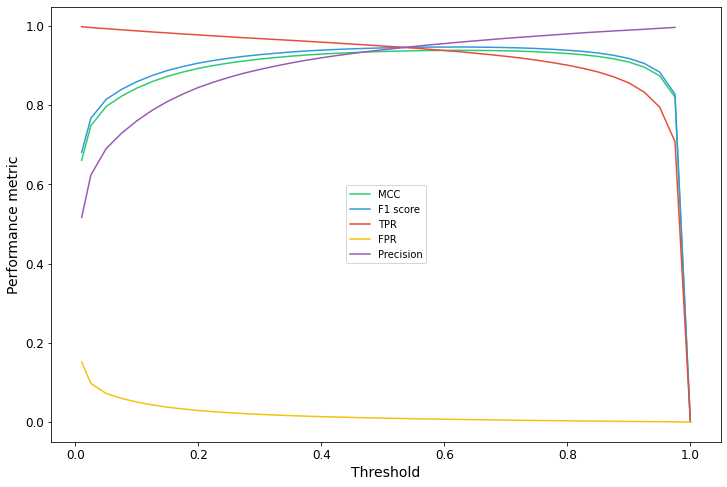

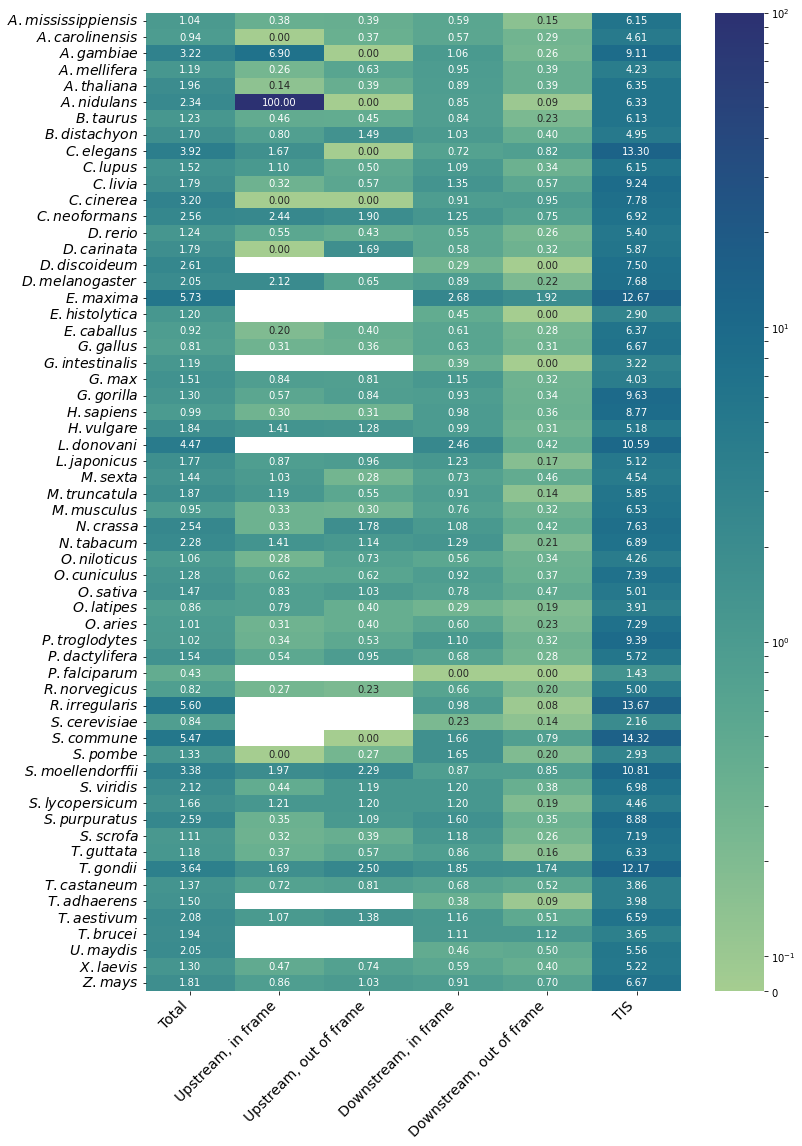

In [36]:
best_threshold_netstart_overall = calculate_error_rates(netstart_overall_df, 
                                                        species_list, 
                                                        "netstart")

Best threshold:  0.625
Best MCC:  0.940181984329319
Best F1:  0.9483681369185558
Best TPR:  0.9384806961084748
Best FPR:  0.0065835701101271335
Best precision:  0.9584661359794424
ROC:  0.9972951621809573
PR:  0.9870506936788441


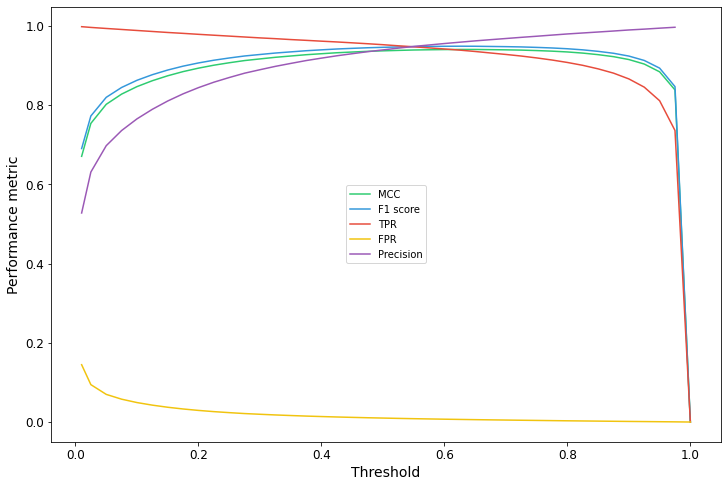

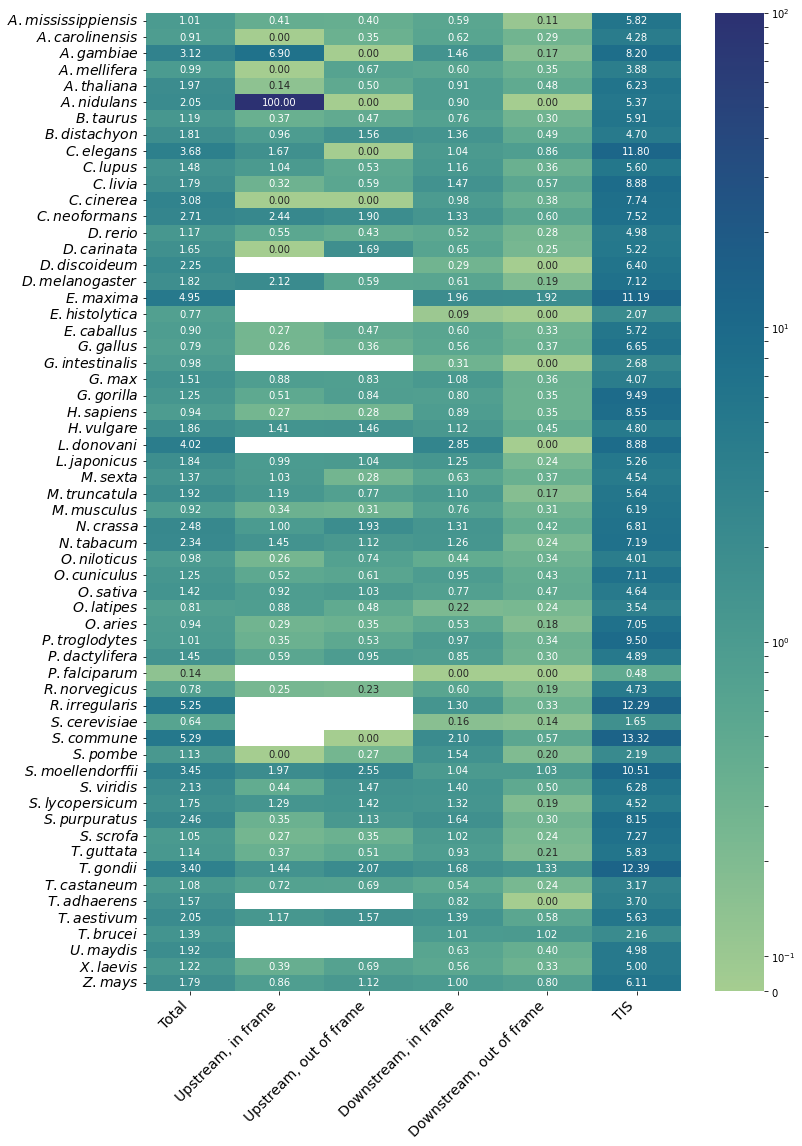

In [37]:
best_threshold_netstart_group = calculate_error_rates(netstart_group_df, 
                                                      species_list,
                                                      "netstart_group")

Best threshold:  0.05
Best MCC:  0.9106464931476632
Best F1:  0.9229344891435901
Best TPR:  0.9144212932121224
Best FPR:  0.010867536346101997
Best precision:  0.9316076891752201
ROC:  0.995200382264358
PR:  0.9780660696157525


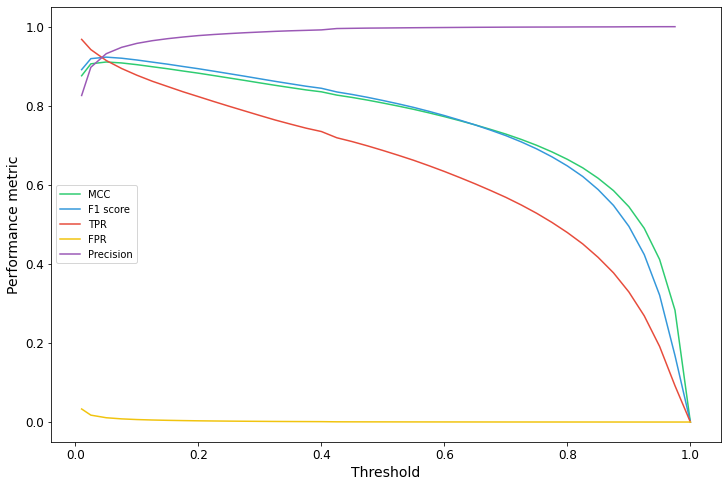

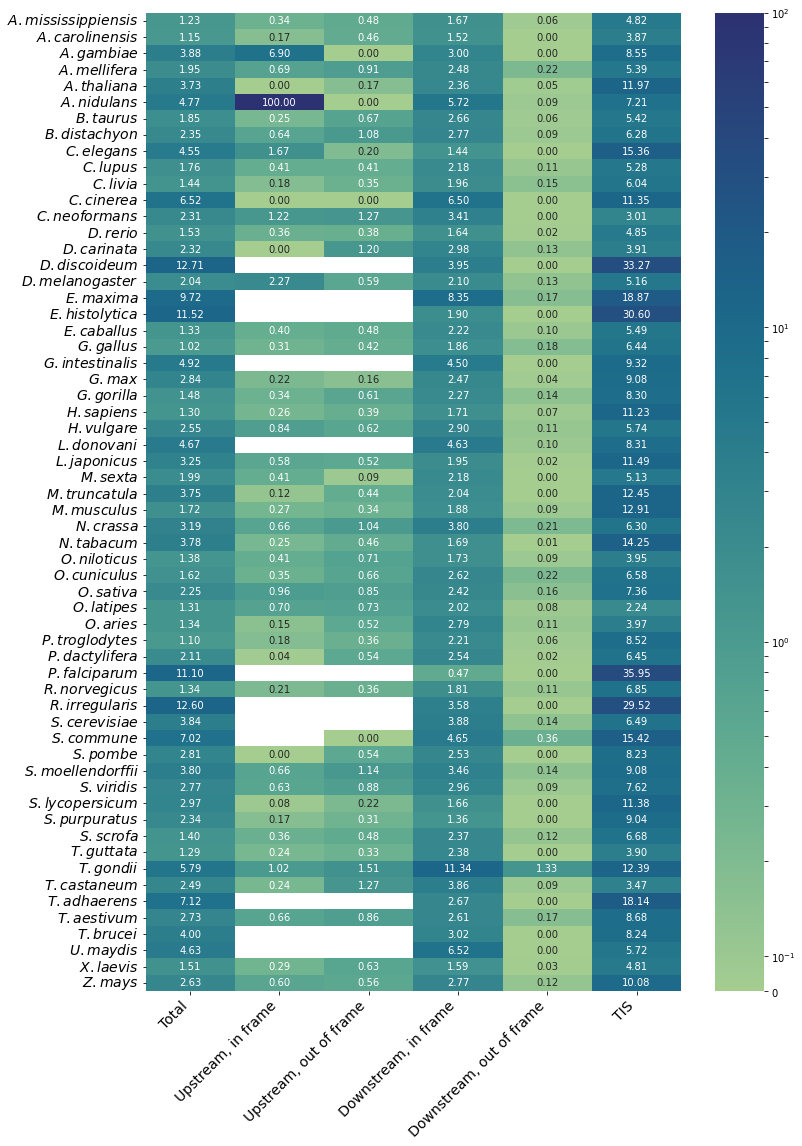

In [38]:
best_threshold_tis_transformer = calculate_error_rates(TIS_transformer_df, 
                                                       species_list,
                                                       "tis_transformer")

Best threshold:  0.625
Best MCC:  0.932989580107181
Best F1:  0.942107435763632
Best TPR:  0.9297844646462576
Best FPR:  0.007131924424995334
Best precision:  0.9547614411930309
ROC:  0.9966445171627273
PR:  0.9841349309341263


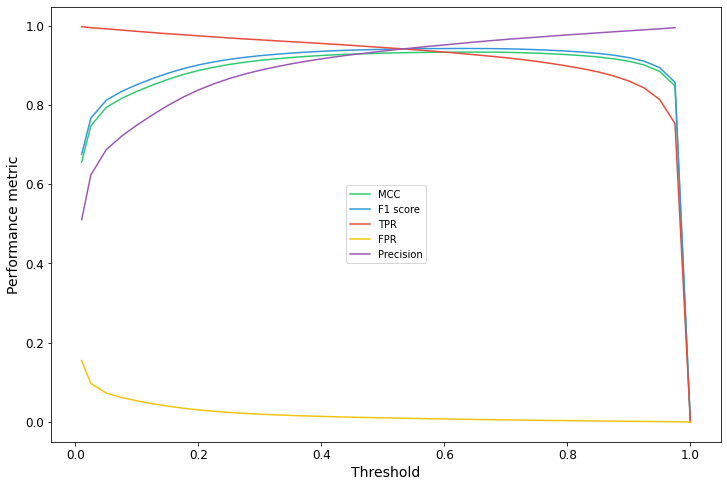

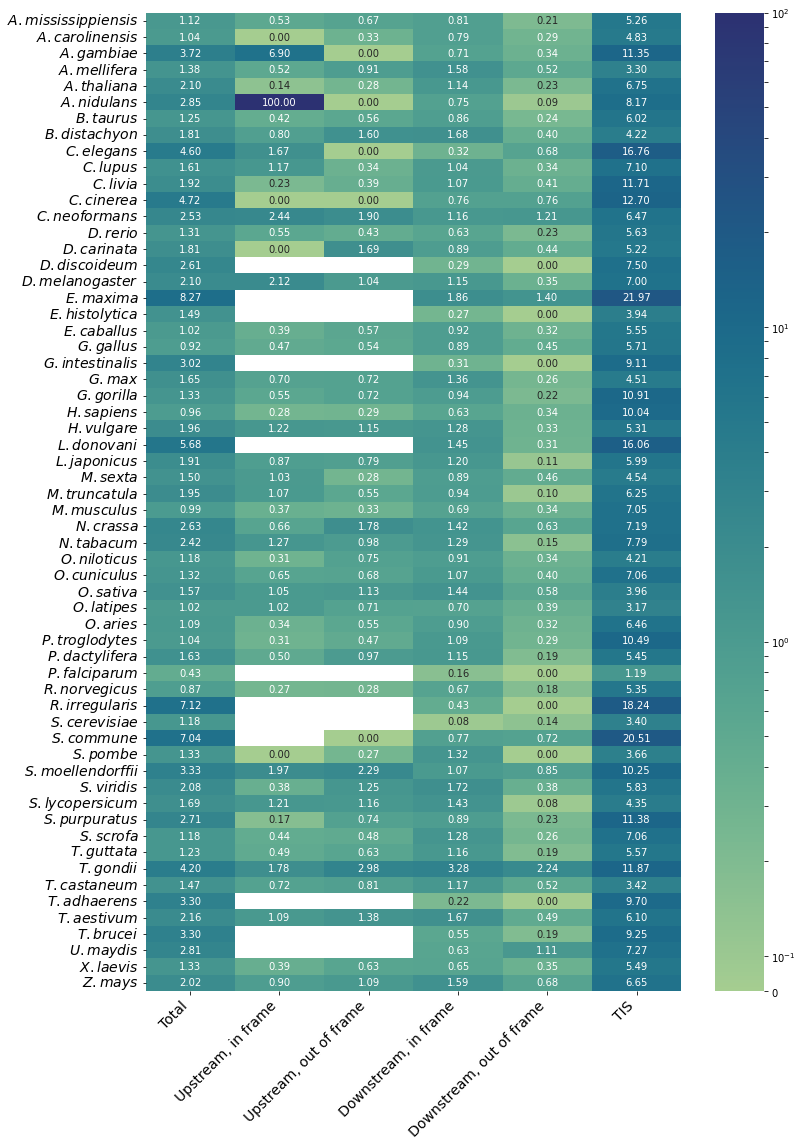

In [39]:
best_threshold_esm2 = calculate_error_rates(esm2_finetuned_df, 
                                            species_list,
                                            "esm2_finetuned")

Best threshold:  0.625
Best MCC:  0.748366557450075
Best F1:  0.781824868308609
Best TPR:  0.7571512027139211
Best FPR:  0.029095962005101936
Best precision:  0.808160809517298
ROC:  0.9634844935700029
PR:  0.8589858249581059


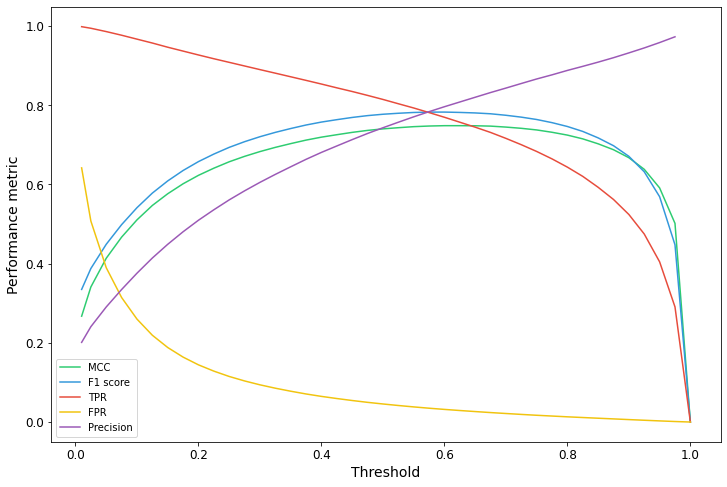

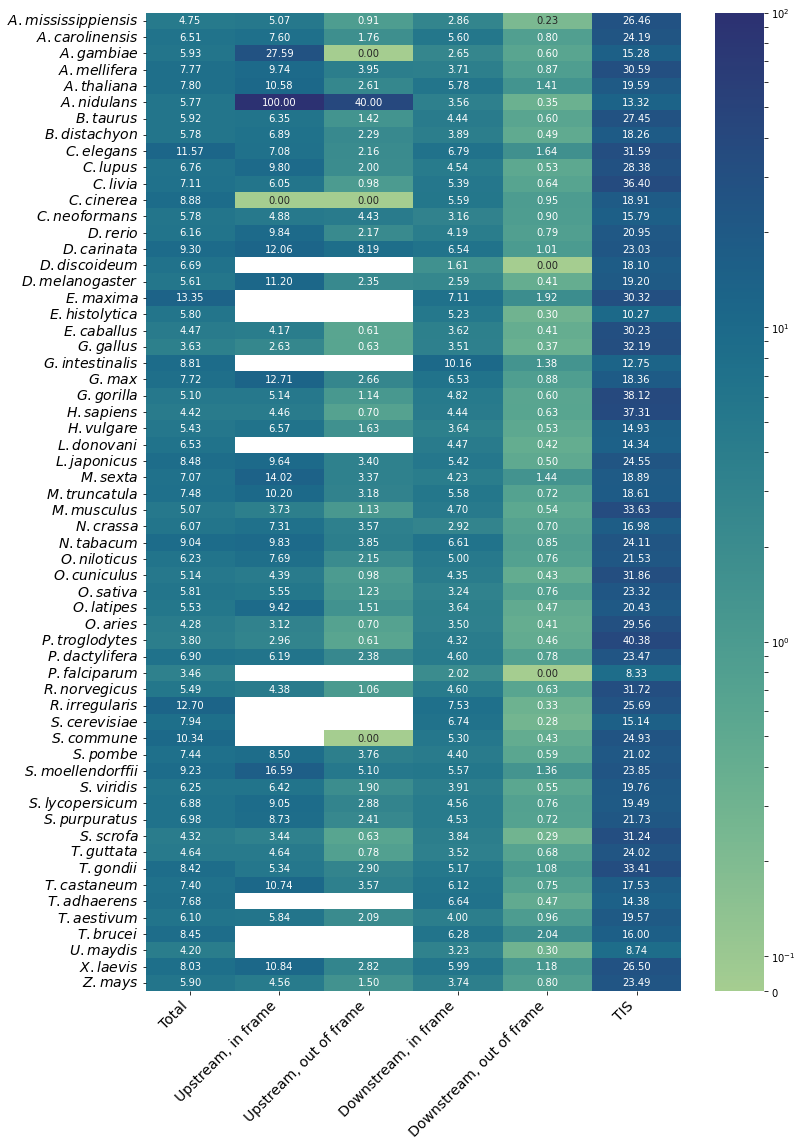

In [40]:
best_threshold_netstart1 = calculate_error_rates(netstart1_df, species_list, "netstart1")

## Calculate MCCs

In [41]:
def calculate_and_output_latex_mcc_table_with_filter(netstart_df, best_threshold_netstart,
                                                     netstart_group_df, best_threshold_netstart_group,
                                                     esm2_finetuned_df, best_threshold_esm2_finetuned,
                                                     netstart1_df, best_threshold_netstart1,
                                                     TIS_transformer_df, best_threshold_TIS_transformer,
                                                     AUGUSTUS_df, tiberius_df,
                                                     groups_dict):
    """
    Calculate MCC scores and output a LaTeX table comparing different models.
    Includes MCC scores calculated with and without Gnomon annotations.
    An additional row shows the best threshold for each model.
    
    Args:
        groups_dict: Dictionary with group names as keys and species lists as values
                    e.g. {'H. sapiens': ['homo_sapiens'], 'Vertebrates': vertebrates_list}
    """
    
    def __calculate_mcc__(species_group_df, best_threshold):
        # Binary predictions for threshold-dependent metrics
        binary_preds = (species_group_df['preds'] >= best_threshold).astype(int)
        
        # Calculate MCC
        return matthews_corrcoef(species_group_df["label"], binary_preds)
    
    def __filter_gnomon__(df):
        # Remove rows where 'annotation_source' is 'Gnomon'
        return df[df['annotation_source'] != 'Gnomon']

    # Store results
    results = {model: {} for model in ['AUGUSTUS', 'Tiberius', 'TIS Transformer', 'NetStart 1.0A', 'NetStart 2.0A', 'NetStart 2.0', 'NetStart 2.0 (Group)']}
    thresholds = {
        'AUGUSTUS': 0.5,
        'Tiberius': 0.5,
        'TIS Transformer': best_threshold_TIS_transformer,
        'NetStart 1.0A': best_threshold_netstart1,
        'NetStart 2.0A': best_threshold_esm2_finetuned,
        'NetStart 2.0': best_threshold_netstart,
        'NetStart 2.0 (Group)': best_threshold_netstart_group
    }

    # Calculate MCC for each group
    for group_name, species_list in groups_dict.items():
        # Extract group data
        netstart_group = netstart_df[netstart_df["species"].isin(species_list)]
        netstart_group_subset = netstart_group_df[netstart_group_df["species"].isin(species_list)]
        esm2_group = esm2_finetuned_df[esm2_finetuned_df["species"].isin(species_list)]
        netstart1_group = netstart1_df[netstart1_df["species"].isin(species_list)]
        tis_group = TIS_transformer_df[TIS_transformer_df["species"].isin(species_list)]
        augustus_group = AUGUSTUS_df[AUGUSTUS_df["species"].isin(species_list)]
        tiberius_group = tiberius_df[tiberius_df["species"].isin(species_list)]

        assert netstart_group.shape[0] == augustus_group.shape[0] == netstart_group_subset.shape[0] == esm2_group.shape[0] == netstart1_group.shape[0] == tis_group.shape[0]
        
        # Filter out Gnomon annotations
        netstart_group_no_gnomon = __filter_gnomon__(netstart_group)
        netstart_group_subset_no_gnomon = __filter_gnomon__(netstart_group_subset)
        esm2_group_no_gnomon = __filter_gnomon__(esm2_group)
        netstart1_group_no_gnomon = __filter_gnomon__(netstart1_group)
        tis_group_no_gnomon = __filter_gnomon__(tis_group)
        augustus_group_no_gnomon = __filter_gnomon__(augustus_group)
        tiberius_group_no_gnomon = __filter_gnomon__(tiberius_group)
        
        # Calculate MCC for both with and without Gnomon annotations
        results['NetStart 2.0'][group_name] = f"{__calculate_mcc__(netstart_group, best_threshold_netstart):.3f} ({__calculate_mcc__(netstart_group_no_gnomon, best_threshold_netstart):.3f})"
        results['NetStart 2.0 (Group)'][group_name] = f"{__calculate_mcc__(netstart_group_subset, best_threshold_netstart_group):.3f} ({__calculate_mcc__(netstart_group_subset_no_gnomon, best_threshold_netstart_group):.3f})"
        results['NetStart 2.0A'][group_name] = f"{__calculate_mcc__(esm2_group, best_threshold_esm2_finetuned):.3f} ({__calculate_mcc__(esm2_group_no_gnomon, best_threshold_esm2_finetuned):.3f})"
        results['NetStart 1.0A'][group_name] = f"{__calculate_mcc__(netstart1_group, best_threshold_netstart1):.3f} ({__calculate_mcc__(netstart1_group_no_gnomon, best_threshold_netstart1):.3f})"
        results['TIS Transformer'][group_name] = f"{__calculate_mcc__(tis_group, best_threshold_TIS_transformer):.3f} ({__calculate_mcc__(tis_group_no_gnomon, best_threshold_TIS_transformer):.3f})"
        results['AUGUSTUS'][group_name] = f"{__calculate_mcc__(augustus_group, 0.5):.3f} ({__calculate_mcc__(augustus_group_no_gnomon, 0.5):.3f})"
        results['Tiberius'][group_name] = f"{__calculate_mcc__(tiberius_group, 0.5):.3f} ({__calculate_mcc__(tiberius_group_no_gnomon, 0.5):.3f})"

    # Create the MCC scores table
    data = []
    for model, scores in results.items():
        row = [model] + [scores[group] for group in groups_dict.keys()]
        data.append(row)
    
    # Add the thresholds as the last row
    threshold_row = ['Best Threshold'] + [f"{thresholds[model]:.3f}" for model in results.keys()]
    #data.append(threshold_row)

    print(threshold_row)
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['Model'] + list(groups_dict.keys()))
    
    # Convert the DataFrame to LaTeX
    latex_table = df.to_latex(index=False, escape=False, caption="MCC Scores with Best Thresholds (With and Without Gnomon)")
    
    # Print the LaTeX table
    print(latex_table)


#For systematic groups overall
groups = {
    'H. sapiens': ["homo_sapiens"],
    'Vertebrates': vertebrates_list,
    'Invertebrates': invertebrates_list,
    'Plants': plants_list,
    'Fungi': fungi_list,
    'Protozoa': protozoa_list
}

calculate_and_output_latex_mcc_table_with_filter(
    netstart_overall_df, best_threshold_netstart_overall,
    netstart_group_df, best_threshold_netstart_group,
    esm2_finetuned_df, best_threshold_esm2,
    netstart1_df, best_threshold_netstart1,
    TIS_transformer_df, best_threshold_tis_transformer,
    augustus_df, tiberius_df,
    groups
)


#For species with Tiberius predictions
groups = {
    #'H. sapiens': ["homo_sapiens"],
    'D. melanogaster': ["drosophila_melanogaster"],
    'A. thaliana': ["arabidopsis_thaliana"],
    'C. neoformans': ["cryptococcus_neoformans"],
    'T. gondii': ["toxoplasma_gondii"]
}

calculate_and_output_latex_mcc_table_with_filter(
    netstart_overall_df, best_threshold_netstart_overall,
    netstart_group_df, best_threshold_netstart_group,
    esm2_finetuned_df, best_threshold_esm2,
    netstart1_df, best_threshold_netstart1,
    TIS_transformer_df, best_threshold_tis_transformer,
    augustus_df, tiberius_df,
    groups
)


['Best Threshold', '0.500', '0.500', '0.050', '0.625', '0.625', '0.625', '0.625']
\begin{table}
\caption{MCC Scores with Best Thresholds (With and Without Gnomon)}
\begin{tabular}{lllllll}
\toprule
Model & H. sapiens & Vertebrates & Invertebrates & Plants & Fungi & Protozoa \\
\midrule
AUGUSTUS & 0.695 (0.704) & 0.750 (0.757) & 0.741 (0.701) & 0.616 (0.626) & 0.647 (0.647) & 0.436 (0.436) \\
Tiberius & 0.790 (0.794) & 0.790 (0.794) & 0.881 (0.881) & 0.755 (0.755) & 0.765 (0.765) & 0.732 (0.732) \\
TIS Transformer & 0.883 (0.862) & 0.919 (0.910) & 0.917 (0.897) & 0.907 (0.908) & 0.863 (0.863) & 0.826 (0.826) \\
NetStart 1.0A & 0.602 (0.641) & 0.695 (0.752) & 0.769 (0.787) & 0.775 (0.810) & 0.809 (0.809) & 0.794 (0.794) \\
NetStart 2.0A & 0.912 (0.930) & 0.933 (0.942) & 0.928 (0.911) & 0.936 (0.945) & 0.905 (0.905) & 0.900 (0.900) \\
NetStart 2.0 & 0.910 (0.923) & 0.937 (0.940) & 0.936 (0.926) & 0.939 (0.950) & 0.925 (0.925) & 0.925 (0.925) \\
NetStart 2.0 (Group) & 0.915 (0.927) & 0.939

In [42]:
def visualize_mcc(netstart_df, best_threshold_netstart,
                          netstart_species_shuffled_df, best_threshold_species_shuffled,
                          best_threshold_species_shuffled_group, netstart_species_shuffled_group_specific_df,
                          best_threshold_species_unknown, netstart_species_unknown_df,
                          title):
    
    def __calculate_mcc__(preds_df, best_threshold):
        vertebrates_df = preds_df[preds_df["species"].isin(vertebrates_list)]
        invertebrates_df = preds_df[preds_df["species"].isin(invertebrates_list)]
        plants_df = preds_df[preds_df["species"].isin(plants_list)]
        fungi_df = preds_df[preds_df["species"].isin(fungi_list)]
        protozoa_df = preds_df[preds_df["species"].isin(protozoa_list)]

        # Binary predictions for threshold-dependent metrics
        binary_preds_vertebrates = (vertebrates_df['preds'] >= best_threshold).astype(int)
        binary_preds_invertebrates = (invertebrates_df['preds'] >= best_threshold).astype(int)
        binary_preds_plants = (plants_df['preds'] >= best_threshold).astype(int)
        binary_preds_fungi = (fungi_df['preds'] >= best_threshold).astype(int)
        binary_preds_protozoa = (protozoa_df['preds'] >= best_threshold).astype(int)
        
        # Calculate MCC
        return [round(matthews_corrcoef(vertebrates_df["label"], binary_preds_vertebrates), 3),
                round(matthews_corrcoef(invertebrates_df["label"], binary_preds_invertebrates), 3),
                round(matthews_corrcoef(plants_df["label"], binary_preds_plants), 3),
                round(matthews_corrcoef(fungi_df["label"], binary_preds_fungi), 3),
                round(matthews_corrcoef(protozoa_df["label"], binary_preds_protozoa), 3)]
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 6))  # One axes for the plot

    # Create non-TIS plot on the first subplot (fig) and make bars wider
    bar_width = 0.21  # Wider bars for non-TIS plot
    index = np.arange(5)  # Sequence types for non-TIS

    mccs_netstart = __calculate_mcc__(netstart_df, best_threshold_netstart)
    mccs_species_shuffled = __calculate_mcc__(netstart_species_shuffled_df, best_threshold_species_shuffled)
    mccs_species_shuffled_group = __calculate_mcc__(best_threshold_species_shuffled_group, netstart_species_shuffled_group_specific_df)
    mccs_species_unknown = __calculate_mcc__(best_threshold_species_unknown, netstart_species_unknown_df)

    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6', '#e67e22', '#1abc9c', '#34495e']

    # Plot bars for each of the MCC values
    bar1 = ax.bar(index, mccs_species_shuffled, bar_width, label='Random', color=colors[0])
    bar2 = ax.bar(index + 1 * bar_width, mccs_species_unknown, bar_width, label='Unknown', color=colors[1])
    bar3 = ax.bar(index + 2 * bar_width, mccs_species_shuffled_group, bar_width, label='Random \n(Systematic group)', color=colors[2])
    bar4 = ax.bar(index + 3 * bar_width, mccs_netstart, bar_width, label='True', color=colors[3])

    # Labels and title
    ax.set_ylabel('MCC', fontsize=14)
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(['Vertebrates', 'Invertebrates', 'Plants', 'Fungi', 'Protozoa'], fontsize=13)
    ax.legend(title="Species label", fontsize=11, title_fontsize=12).get_title().set_fontweight('bold')

    ax.set_ylim([0.88,0.95])

    # Adding value annotations on top of each bar
    def autolabel(bars, ax):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    '%.3f' % height, ha='center', va='bottom', fontsize=10)

    autolabel(bar1, ax)
    autolabel(bar2, ax)
    autolabel(bar3, ax)
    autolabel(bar4, ax)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig("../../results/evaluation/netstart2_performance/mcc_species_input.png")
    plt.show()



## Calculate AUC metrics

[(0.54578602, 0.8544913, 0.69848331), (0.25187832, 0.71827158, 0.67872193), (0.20344718, 0.56074869, 0.65649508), (0.21607792, 0.39736958, 0.61948028), (0.25307401, 0.23772973, 0.48316271), (0.18195582, 0.11955283, 0.23136943)]
                 H. sapiens  Vertebrates  Plants  Invertebrates  Fungi  \
NetStart 1.0A         0.949        0.959   0.964          0.962  0.967   
TIS Transformer       0.994        0.997   0.994          0.995  0.987   
NetStart 2.0A         0.998        0.998   0.995          0.994  0.989   
NetStart 2.0          0.998        0.998   0.996          0.995  0.993   

                 Protozoa  
NetStart 1.0A       0.959  
TIS Transformer     0.981  
NetStart 2.0A       0.990  
NetStart 2.0        0.993  
                 H. sapiens  Vertebrates  Plants  Invertebrates  Fungi  \
NetStart 1.0A         0.667        0.789   0.897          0.898  0.941   
TIS Transformer       0.955        0.980   0.979          0.985  0.974   
NetStart 2.0A         0.972        0.98

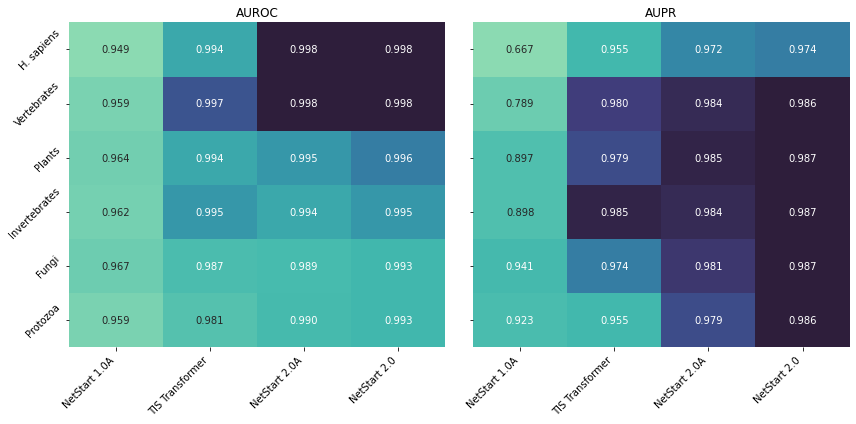

[(0.54578602, 0.8544913, 0.69848331), (0.25187832, 0.71827158, 0.67872193), (0.20344718, 0.56074869, 0.65649508), (0.21607792, 0.39736958, 0.61948028), (0.25307401, 0.23772973, 0.48316271), (0.18195582, 0.11955283, 0.23136943)]
                 H. sapiens  Vertebrates  Plants  Invertebrates  Fungi  \
NetStart 1.0A         0.947        0.964   0.968          0.964  0.967   
TIS Transformer       0.990        0.994   0.993          0.992  0.987   
NetStart 2.0A         0.997        0.997   0.995          0.991  0.989   
NetStart 2.0          0.997        0.997   0.996          0.993  0.993   

                 Protozoa  
NetStart 1.0A       0.959  
TIS Transformer     0.981  
NetStart 2.0A       0.990  
NetStart 2.0        0.993  
                 H. sapiens  Vertebrates  Plants  Invertebrates  Fungi  \
NetStart 1.0A         0.718        0.857   0.930          0.917  0.941   
TIS Transformer       0.944        0.978   0.983          0.981  0.974   
NetStart 2.0A         0.979        0.98

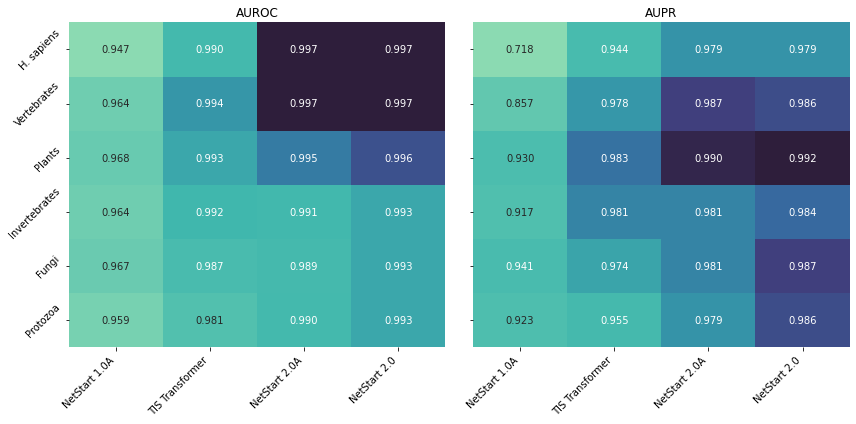

In [43]:
def calculate_and_plot_auc_heatmap(netstart_df,
                                 esm2_finetuned_df,
                                 netstart1_df,
                                 TIS_transformer_df,
                                 groups_dict,
                                 title):
    """
    Calculate AUROC and AUPR metrics and create a heatmap comparing different models.
    Uses a custom colormap that emphasizes differences in high values (close to 1.0).
    
    Args:
        groups_dict: Dictionary with group names as keys and species lists as values
                    e.g. {'H. sapiens': ['homo_sapiens'], 'Vertebrates': vertebrates_list}
    """
    
    def __calculate_metrics__(species_group_df):
        auroc = roc_auc_score(species_group_df["label"], species_group_df["preds"])
        aupr = average_precision_score(species_group_df["label"], species_group_df["preds"])
        return [auroc, aupr]

    # Store results
    results = {}
    metric_names = ['AUROC', 'AUPR']
    model_names = ['NetStart 1.0A', 'TIS Transformer', 'NetStart 2.0A', 'NetStart 2.0']
    
    # Calculate metrics for each group
    for group_name, species_list in groups_dict.items():
        netstart1_group = netstart1_df[netstart1_df["species"].isin(species_list)]
        netstart_group = netstart_df[netstart_df["species"].isin(species_list)]
        esm2_group = esm2_finetuned_df[esm2_finetuned_df["species"].isin(species_list)]
        tis_group = TIS_transformer_df[TIS_transformer_df["species"].isin(species_list)]
        
        metrics_netstart1 = __calculate_metrics__(netstart1_group)
        metrics_netstart = __calculate_metrics__(netstart_group)
        metrics_esm2 = __calculate_metrics__(esm2_group)
        metrics_tis = __calculate_metrics__(tis_group)
        
        results[group_name] = {
            'NetStart 1.0A': metrics_netstart1,
            'TIS Transformer': metrics_tis,
            'NetStart 2.0A': metrics_esm2,
            'NetStart 2.0': metrics_netstart
        }
    
    # Create figure with simple subplot layout
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Create custom colormap that emphasizes differences near 1.0
    
    # Create colors for the custom colormap
    colors = [(0.95, 0.95, 0.95),  # Very light gray for lowest values
            (0.7, 0.7, 0.9),      # Light blue-gray
            (0.4, 0.4, 0.8),      # Medium blue
            (0.2, 0.2, 0.75),     # Medium-deep blue
            (0.1, 0.1, 0.7),      # Deep blue
            (0, 0, 0.6)]          # Very deep blue

    # Create colors for the custom colormap
    colors = [(0.95, 0.95, 0.95),    # Very light gray for lowest values
            (0.7, 0.85, 0.8),       # Light green-gray
            (0.4, 0.7, 0.7),        # Teal
            (0.3, 0.5, 0.6),        # Blue-green
            (0.2, 0.3, 0.5),        # Deep blue-green
            (0.1, 0.2, 0.4)]        # Dark blue
    
    colors = sns.color_palette("mako", as_cmap=False)[::-1]

    print(colors)
    
    # Create heatmap for each metric
    for idx, metric in enumerate(metric_names):
        # Create data matrix for this metric
        data_matrix = []
        for group in groups_dict.keys():
            row = []
            for model in model_names:
                row.append(round(results[group][model][idx], 3))
            data_matrix.append(row)
        
        df = pd.DataFrame(data_matrix, 
                         index=list(groups_dict.keys()),
                         columns=model_names)
        
        # Get min and max values
        vmin = df.min().min()
        vmax = df.max().max()  # Fix maximum to 1.0 for metrics

        # Position these colors in the colormap with emphasis on high values
        positions = [0, vmax-vmin*0.10, vmax-vmin*0.05, vmax-vmin*0.025, vmax-vmin*0.01,  1.0]
        
        custom_cmap = LinearSegmentedColormap.from_list('xx', 
                                                    list(zip(positions, colors)))
        
        print(df.T)
        # Plot heatmap with custom colormap
        sns.heatmap(df, 
                   ax=axes[idx],
                   cmap=custom_cmap,
                   vmin=vmin,
                   vmax=vmax,
                   annot=True,
                   fmt='.3f',
                   cbar=False,
                   cbar_kws={'label': metric})
        
        axes[idx].set_title(metric)
        axes[idx].set_ylabel('')
        if idx > 0:
            axes[idx].set_yticklabels([], rotation=45)
        
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
        axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig("../../results/evaluation/benchmark/"+title+".png", bbox_inches='tight')
    return fig

# Usage example:
groups = {
    'H. sapiens': ["homo_sapiens"],
    'Vertebrates': vertebrates_list,
    'Plants': plants_list,
    'Invertebrates': invertebrates_list,
    'Fungi': fungi_list,
    'Protozoa': protozoa_list
}

fig = calculate_and_plot_auc_heatmap(
    netstart_overall_df,
    esm2_finetuned_df,
    netstart1_df,
    TIS_transformer_df,
    groups,
    "auc_performance"
)

plt.show()

fig = calculate_and_plot_auc_heatmap(
    netstart_overall_df[netstart_overall_df["annotation_source"] != "Gnomon"],
    esm2_finetuned_df[esm2_finetuned_df["annotation_source"] != "Gnomon"],
    netstart1_df[netstart1_df["annotation_source"] != "Gnomon"],
    TIS_transformer_df[TIS_transformer_df["annotation_source"] != "Gnomon"],
    groups,
    "auc_performance_refseq"
)

plt.show()

## Calculate error rates divided on systematic group and sequence type

In [44]:
def visualize_error_rates(netstart_df, best_threshold_netstart,
                          esm2_finetuned_df, best_threshold_esm2_finetuned,
                          TIS_transformer_df, best_threshold_TIS_transformer,
                          augustus_df, tiberius_df,
                          species_group, 
                          title):
    
    def __calculate_error_rates__(species_group_df, best_threshold):
        up_in_data = species_group_df[species_group_df["seq_type"] == "Upstream, in frame"]
        up_out_data = species_group_df[species_group_df["seq_type"] == "Upstream, out of frame"]
        down_in_data = species_group_df[species_group_df["seq_type"] == "Downstream, in frame"]
        down_out_data = species_group_df[species_group_df["seq_type"] == "Downstream, out of frame"]
        TIS_data = species_group_df[species_group_df["seq_type"] == "TIS"]

        error_rate_total = round(np.mean(np.array(species_group_df["label"]) != (np.array(species_group_df["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_up_in = round(np.mean(np.array(up_in_data["label"]) != (np.array(up_in_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_up_out = round(np.mean(np.array(up_out_data["label"]) != (np.array(up_out_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_down_in = round(np.mean(np.array(down_in_data["label"]) != (np.array(down_in_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_down_out = round(np.mean(np.array(down_out_data["label"]) != (np.array(down_out_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_TIS = round(np.mean(np.array(TIS_data["label"]) != (np.array(TIS_data["preds"]) >= best_threshold).astype(int)) * 100, 3)

        return [error_rate_total, error_rate_up_in, error_rate_up_out, error_rate_down_in, error_rate_down_out], [error_rate_TIS]
    
    # Extract group data for the different models
    netstart_species_group_df = netstart_df[netstart_df["species"].isin(species_group)]
    esm2_finetuned_species_group_df = esm2_finetuned_df[esm2_finetuned_df["species"].isin(species_group)]
    TIS_transformer_species_group_df = TIS_transformer_df[TIS_transformer_df["species"].isin(species_group)]
    augustus_species_group_df = augustus_df[augustus_df["species"].isin(species_group)]
    tiberius_species_group_df = tiberius_df[tiberius_df["species"].isin(species_group)]

    error_rates_tiberius = __calculate_error_rates__(tiberius_species_group_df, 0.5)
    error_rates_netstart = __calculate_error_rates__(netstart_species_group_df, best_threshold_netstart)
    error_rates_esm2 = __calculate_error_rates__(esm2_finetuned_species_group_df, best_threshold_esm2_finetuned)
    error_rates_tis_transformer = __calculate_error_rates__(TIS_transformer_species_group_df, best_threshold_TIS_transformer)
    error_rates_augustus = __calculate_error_rates__(augustus_species_group_df, 0.5)

    non_tis_error_rates = error_rates_augustus[0] + error_rates_tis_transformer[0] + error_rates_esm2[0] + error_rates_netstart[0] + error_rates_tiberius[0]
    tis_error_rates = error_rates_augustus[1] + error_rates_tis_transformer[1] + error_rates_esm2[1] + error_rates_netstart[1] + error_rates_tiberius[1]

    # Find the maximum value
    max_value_non_tis = max(non_tis_error_rates)
    max_value_tis = max(tis_error_rates)

    # Create figure with 2 subplots side by side (non-TIS plot left, TIS plot right)
    fig = plt.figure(figsize=(16, 4))  # Wide figure
    gs = GridSpec(1, 2, width_ratios=[4.5, 1])  # Non-TIS plot (ax1) takes 3 parts, TIS plot (ax2) takes 1 part

    ax1 = fig.add_subplot(gs[0])  # Left plot (non-TIS)
    ax2 = fig.add_subplot(gs[1])  # Right plot (TIS)

    # Set ylim with some padding
    ax1.set_ylim([0, max_value_non_tis * 1.07])  # 10% padding
    ax2.set_ylim([0, max_value_tis * 1.07])  # Same padding for ax2

    # Create non-TIS plot on the first subplot (ax1) and make bars wider
    bar_width = 0.18  # Wider bars for non-TIS plot
    index = np.arange(5)  # Sequence types for non-TIS

    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6']

    bar1 = ax1.bar(index, error_rates_augustus[0], bar_width, label='AUGUSTUS', color=colors[0])
    bar2 = ax1.bar(index + 1 * bar_width, error_rates_tiberius[0], bar_width, label='Tiberius', color=colors[4])
    bar3 = ax1.bar(index + 2 * bar_width, error_rates_tis_transformer[0], bar_width, label='TIS Transformer', color=colors[1])
    bar4 = ax1.bar(index + 3 * bar_width, error_rates_esm2[0], bar_width, label='NetStart 2.0A', color=colors[2])
    bar5 = ax1.bar(index + 4 * bar_width, error_rates_netstart[0], bar_width, label='NetStart 2.0', color=colors[3])
    
    #ax1.set_xlabel('Sequence type', fontsize=14)
    ax1.set_ylabel('Error rate (%)', fontsize=14)
    #ax1.set_title(f'{title}', fontsize=16)
    ax1.set_xticks(index + bar_width)
    ax1.set_xticklabels(['Total', 'Upstream,\nin frame', 'Upstream,\nout of frame', 'Downstream,\nin frame', 
                         'Downstream,\nout of frame'], fontsize=14)
    ax1.legend(fontsize=13)
    ax1.tick_params(axis='y', labelsize=14)  # Sets fontsize of y-axis tick labels to 14

    # Adding value annotations on top of each bar
    def autolabel(bars, ax):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    '%.2f' % height, ha='center', va='bottom', fontsize=12)

    autolabel(bar1, ax1)
    autolabel(bar2, ax1)
    autolabel(bar3, ax1)
    autolabel(bar4, ax1)
    autolabel(bar5, ax1)

    # Create TIS plot on the second subplot (ax2) with narrower bars
    bar_width = 0.10  # Narrower bars for TIS plot
    index = np.arange(1)  # Only one sequence type (TIS)
    
    bar1 = ax2.bar(index, error_rates_augustus[1], bar_width, label='AUGUSTUS', color=colors[0])
    bar2 = ax2.bar(index + 1 * bar_width, error_rates_tiberius[1], bar_width, label='Tiberius', color=colors[4])
    bar3 = ax2.bar(index + 2 * bar_width, error_rates_tis_transformer[1], bar_width, label='TIS Transformer', color=colors[1])
    bar4 = ax2.bar(index + 3 * bar_width, error_rates_esm2[1], bar_width, label='NetStart 2.0A', color=colors[2])
    bar5 = ax2.bar(index + 4 * bar_width, error_rates_netstart[1], bar_width, label='NetStart 2.0', color=colors[3])
    
    #ax2.set_xlabel('Sequence type', fontsize=14)
    #ax2.set_ylabel('Error rate', fontsize=14)
    #ax2.set_title(f'{title} - TIS', fontsize=16)
    ax2.set_xticks(index + bar_width)
    ax2.set_xticklabels(['TIS'], fontsize= 14)
    ax2.tick_params(axis='y', labelsize=14)  # Sets fontsize of y-axis tick labels to 14
    #ax2.legend(fontsize=13)

    autolabel(bar1, ax2)
    autolabel(bar2, ax2)
    autolabel(bar3, ax2)
    autolabel(bar4, ax2)
    autolabel(bar5, ax2)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig(f"../../results/evaluation/benchmark/error_rates_{title}.png")
    plt.show()


## H. sapiens

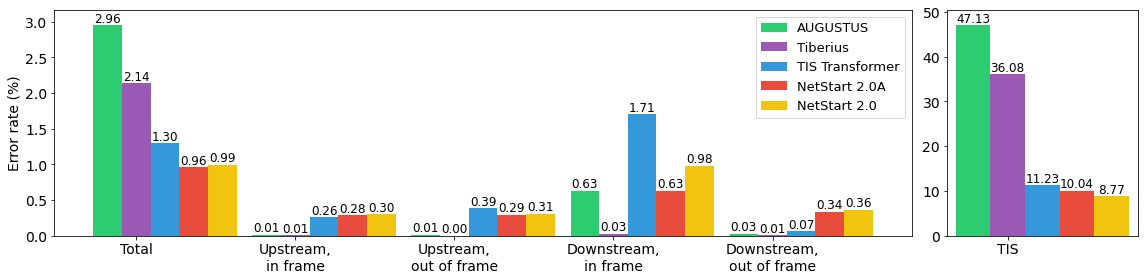

In [45]:
visualize_error_rates(netstart_overall_df, best_threshold_netstart_overall, 
                      esm2_finetuned_df, best_threshold_esm2,
                      TIS_transformer_df, best_threshold_tis_transformer,
                      augustus_df, tiberius_df,
                      ["homo_sapiens"],
                      "homo_sapiens")

## Systematic groups

In [46]:
def visualize_error_rates(netstart_df, best_threshold_netstart,
                          esm2_finetuned_df, best_threshold_esm2_finetuned,
                          TIS_transformer_df, best_threshold_TIS_transformer,
                          augustus_df, 
                          species_group, 
                          title):
    
    def __calculate_error_rates__(species_group_df, best_threshold):
        up_in_data = species_group_df[species_group_df["seq_type"] == "Upstream, in frame"]
        up_out_data = species_group_df[species_group_df["seq_type"] == "Upstream, out of frame"]
        down_in_data = species_group_df[species_group_df["seq_type"] == "Downstream, in frame"]
        down_out_data = species_group_df[species_group_df["seq_type"] == "Downstream, out of frame"]
        TIS_data = species_group_df[species_group_df["seq_type"] == "TIS"]

        error_rate_total = round(np.mean(np.array(species_group_df["label"]) != (np.array(species_group_df["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_up_in = round(np.mean(np.array(up_in_data["label"]) != (np.array(up_in_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_up_out = round(np.mean(np.array(up_out_data["label"]) != (np.array(up_out_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_down_in = round(np.mean(np.array(down_in_data["label"]) != (np.array(down_in_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_down_out = round(np.mean(np.array(down_out_data["label"]) != (np.array(down_out_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_TIS = round(np.mean(np.array(TIS_data["label"]) != (np.array(TIS_data["preds"]) >= best_threshold).astype(int)) * 100, 3)

        return [error_rate_total, error_rate_up_in, error_rate_up_out, error_rate_down_in, error_rate_down_out], [error_rate_TIS]
    
    # Extract group data for the different models
    netstart_species_group_df = netstart_df[netstart_df["species"].isin(species_group)]
    esm2_finetuned_species_group_df = esm2_finetuned_df[esm2_finetuned_df["species"].isin(species_group)]
    TIS_transformer_species_group_df = TIS_transformer_df[TIS_transformer_df["species"].isin(species_group)]
    augustus_species_group_df = augustus_df[augustus_df["species"].isin(species_group)]

    error_rates_netstart = __calculate_error_rates__(netstart_species_group_df, best_threshold_netstart)
    error_rates_esm2 = __calculate_error_rates__(esm2_finetuned_species_group_df, best_threshold_esm2_finetuned)
    error_rates_tis_transformer = __calculate_error_rates__(TIS_transformer_species_group_df, best_threshold_TIS_transformer)
    error_rates_augustus = __calculate_error_rates__(augustus_species_group_df, 0.5)

    non_tis_error_rates = error_rates_augustus[0] + error_rates_tis_transformer[0] + error_rates_esm2[0] + error_rates_netstart[0] 
    tis_error_rates = error_rates_augustus[1] + error_rates_tis_transformer[1] + error_rates_esm2[1] + error_rates_netstart[1]

    # Find the maximum value
    max_value_non_tis = max(non_tis_error_rates)
    max_value_tis = max(tis_error_rates)

    # Create figure with 2 subplots side by side (non-TIS plot left, TIS plot right)
    fig = plt.figure(figsize=(16, 4))  # Wide figure
    gs = GridSpec(1, 2, width_ratios=[4.5, 1])  # Non-TIS plot (ax1) takes 3 parts, TIS plot (ax2) takes 1 part

    ax1 = fig.add_subplot(gs[0])  # Left plot (non-TIS)
    ax2 = fig.add_subplot(gs[1])  # Right plot (TIS)

    # Set ylim with some padding
    ax1.set_ylim([0, max_value_non_tis * 1.07])  # 7% padding
    ax2.set_ylim([0, max_value_tis * 1.07])  # Same padding for ax2

    # Create non-TIS plot on the first subplot (ax1) and make bars wider
    bar_width = 0.18  # Wider bars for non-TIS plot
    index = np.arange(5)  # Sequence types for non-TIS

    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6', '#e67e22', '#1abc9c', '#34495e']

    bar1 = ax1.bar(index, error_rates_augustus[0], bar_width, label='AUGUSTUS', color=colors[0])
    bar2 = ax1.bar(index + 1 * bar_width, error_rates_tis_transformer[0], bar_width, label='TIS Transformer', color=colors[1])
    bar3 = ax1.bar(index + 2 * bar_width, error_rates_esm2[0], bar_width, label='NetStart 2.0A', color=colors[2])
    bar4 = ax1.bar(index + 3 * bar_width, error_rates_netstart[0], bar_width, label='NetStart 2.0', color=colors[3])
    
    #ax1.set_xlabel('Sequence type', fontsize=14)
    ax1.set_ylabel('Error rate (%)', fontsize=14)
    ax1.set_title(f'{title}', fontsize=16)
    ax1.set_xticks(index + bar_width)
    ax1.set_xticklabels(['Total', 'Upstream,\nin frame', 'Upstream,\nout of frame', 'Downstream,\nin frame', 
                         'Downstream,\nout of frame'], fontsize=14)
    ax1.legend(fontsize=13)
    ax1.tick_params(axis='y', labelsize=14)

    # Adding value annotations on top of each bar
    def autolabel(bars, ax):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    '%.2f' % height, ha='center', va='bottom', fontsize=12)

    autolabel(bar1, ax1)
    autolabel(bar2, ax1)
    autolabel(bar3, ax1)
    autolabel(bar4, ax1)
    
    # Create TIS plot on the second subplot (ax2) with narrower bars
    bar_width = 0.10  # Narrower bars for TIS plot
    index = np.arange(1)  # Only one sequence type (TIS)
    
    bar1 = ax2.bar(index, error_rates_augustus[1], bar_width, label='AUGUSTUS', color=colors[0])
    bar2 = ax2.bar(index + 1 * bar_width, error_rates_tis_transformer[1], bar_width, label='TIS Transformer', color=colors[1])
    bar3 = ax2.bar(index + 2 * bar_width, error_rates_esm2[1], bar_width, label='NetStart 2.0A', color=colors[2])
    bar4 = ax2.bar(index + 3 * bar_width, error_rates_netstart[1], bar_width, label='NetStart 2.0', color=colors[3])
    
    #ax2.set_xlabel('Sequence type', fontsize=14)
    #ax2.set_ylabel('Error rate', fontsize=14)
    #ax2.set_title(f'{title} - TIS', fontsize=16)
    ax2.set_xticks(index + bar_width)
    ax2.set_xticklabels(['TIS'], fontsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    #ax2.legend(fontsize=13)

    autolabel(bar1, ax2)
    autolabel(bar2, ax2)
    autolabel(bar3, ax2)
    autolabel(bar4, ax2)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig(f"../../results/evaluation/benchmark/error_rates_{title}.png")
    plt.show()

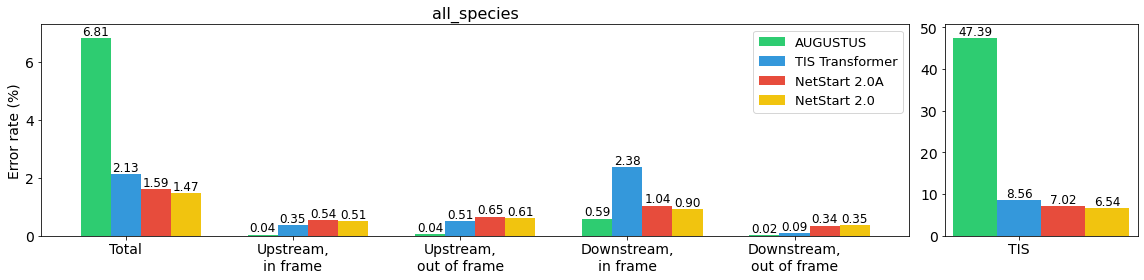

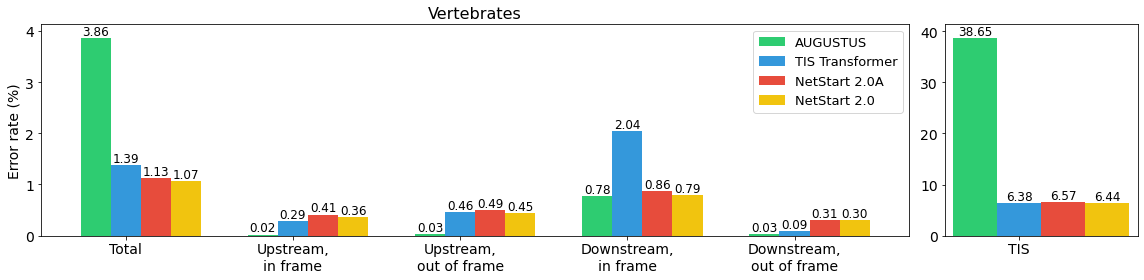

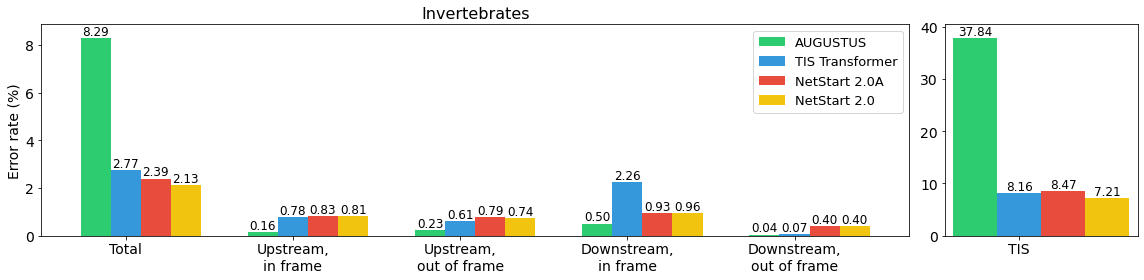

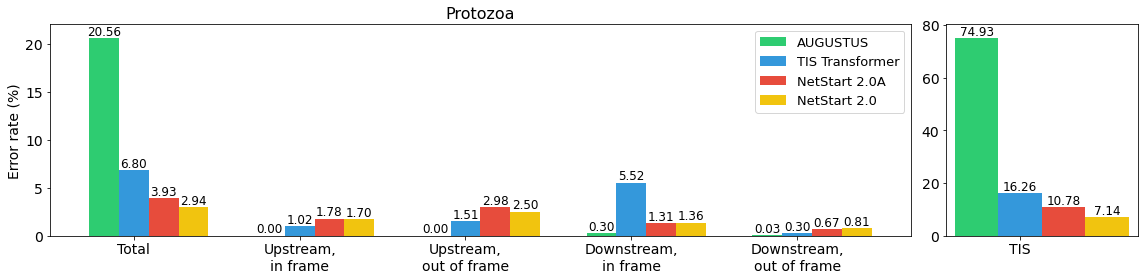

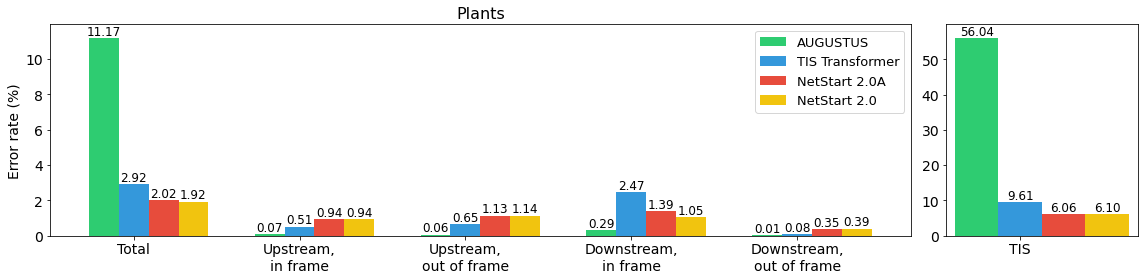

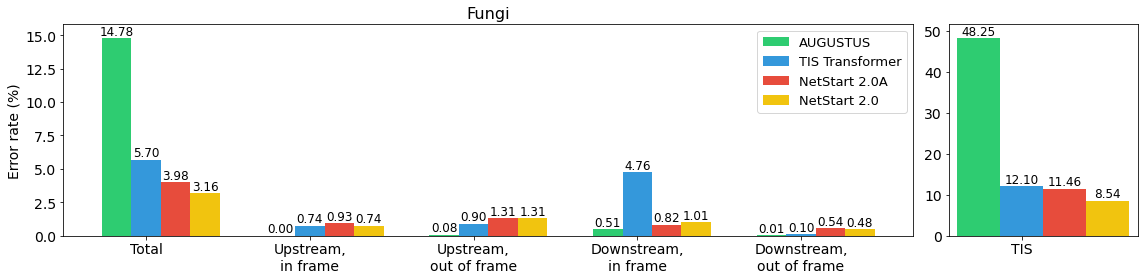

In [47]:
visualize_error_rates(netstart_overall_df, best_threshold_netstart_overall, 
                      esm2_finetuned_df, best_threshold_esm2,
                      TIS_transformer_df, best_threshold_tis_transformer,
                      augustus_df,
                      species_list,
                      "all_species")

visualize_error_rates(netstart_overall_df, best_threshold_netstart_overall, 
                      esm2_finetuned_df, best_threshold_esm2,
                      TIS_transformer_df, best_threshold_tis_transformer,
                      augustus_df,
                      vertebrates_list,
                      "Vertebrates")

visualize_error_rates(netstart_overall_df, best_threshold_netstart_overall, 
                      esm2_finetuned_df, best_threshold_esm2,
                      TIS_transformer_df, best_threshold_tis_transformer,
                      augustus_df,
                      invertebrates_list,
                      "Invertebrates")

visualize_error_rates(netstart_overall_df, best_threshold_netstart_overall, 
                      esm2_finetuned_df, best_threshold_esm2,
                      TIS_transformer_df, best_threshold_tis_transformer,
                      augustus_df,
                      protozoa_list,
                      "Protozoa")

visualize_error_rates(netstart_overall_df, best_threshold_netstart_overall, 
                      esm2_finetuned_df, best_threshold_esm2,
                      TIS_transformer_df, best_threshold_tis_transformer,
                      augustus_df,
                      plants_list,
                      "Plants")

visualize_error_rates(netstart_overall_df, best_threshold_netstart_overall, 
                      esm2_finetuned_df, best_threshold_esm2,
                      TIS_transformer_df, best_threshold_tis_transformer,
                      augustus_df,
                      fungi_list,
                      "Fungi")

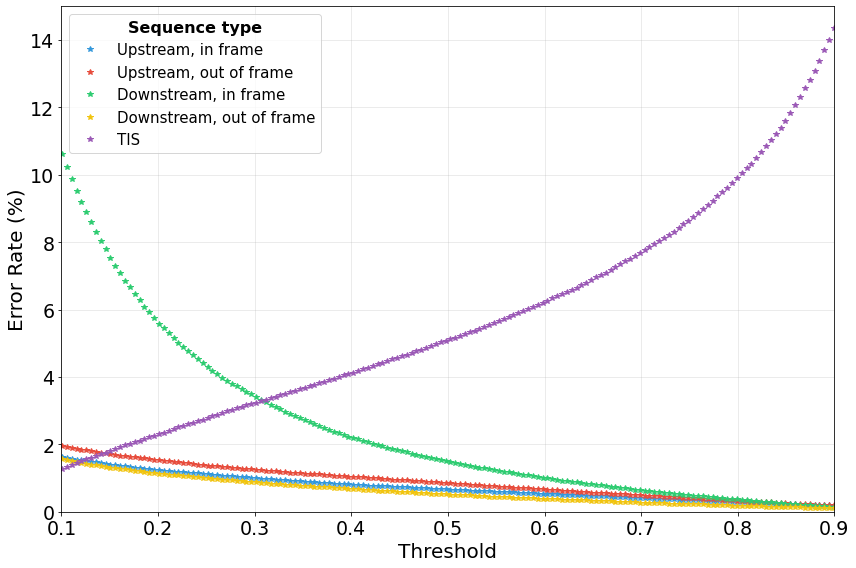

In [48]:
def visualize_error_rates_scatter(netstart_df, title):
    # Define sequence types (excluding 'Total')
    seq_types = ['Upstream, in frame', 'Upstream, out of frame',
                 'Downstream, in frame', 'Downstream, out of frame', 'TIS']
    
    # Create threshold range
    thresholds = np.linspace(0, 1, 200)
    
    # Initialize plot
    plt.figure(figsize=(12, 8))
    
    # Define colors for different sequence types
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f1c40f', '#9b59b6']
    
    # Calculate and plot error rates for each sequence type
    for seq_type, color in zip(seq_types, colors):
        error_rates = []
        # Get data for this sequence type
        type_data = netstart_df[netstart_df["seq_type"] == seq_type]
        
        # Calculate error rate for each threshold
        for threshold in thresholds:
            predictions = (np.array(type_data["preds"]) >= threshold).astype(int)
            labels = np.array(type_data["label"])
            error_rate = np.mean(predictions != labels) * 100
            error_rates.append(error_rate)
        
        # Plot this sequence type
        plt.plot(thresholds, error_rates, '*', label=seq_type, color=color)
    
    # Customize plot
    plt.xlabel('Threshold', fontsize=20)
    plt.ylabel('Error Rate (%)', fontsize=20)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=19)
    plt.title(f'{title}', fontsize=16)
    plt.legend(title="Sequence type", fontsize=15, title_fontsize=16).get_title().set_fontweight('bold')
    plt.grid(True, alpha=0.3)
    
    # Set axis limits
    plt.xlim(0.1, 0.9)
    plt.ylim(0,15)
    
    # Save and show plot
    plt.tight_layout()
    plt.savefig(f"../../results/evaluation/benchmark/error_rates_scatter_{title}.png")
    plt.show()

visualize_error_rates_scatter(netstart_overall_df, "")

# Benchmark on Genes

## Extract genomic sequences
TIS Transformer can predict on sequences up to 30.000 nucleotides; limit genomic datasets to align for all models

In [49]:
TIS_transformer_genomic_df_placeholder = pd.DataFrame()
augustus_genomic_df_placeholder = pd.DataFrame()
tiberius_genomic_df_placeholder = pd.DataFrame()
netstart_overall_genomic_df_placeholder = pd.DataFrame()
netstart_group_genomic_df_placeholder = pd.DataFrame()
esm2_finetuned_genomic_df_placeholder = pd.DataFrame()
netstart1_genomic_df_placeholder = pd.DataFrame()

for species in species_list:
    TIS_transformer_genomic_species = TIS_transformer_genomic_df[(TIS_transformer_genomic_df["species"] == species)]
    genes_for_use = list(set(TIS_transformer_genomic_species["seq_number"]))

    augustus_genomic_df_placeholder_species = augustus_genomic_df[(augustus_genomic_df["seq_number"].isin(genes_for_use)) & (augustus_genomic_df["species"] == species)]
    tiberius_genomic_df_placeholder_species = tiberius_genomic_df[(tiberius_genomic_df["seq_number"].isin(genes_for_use)) & (tiberius_genomic_df["species"] == species)]
    netstart_overall_genomic_df_placeholder_species = netstart_genomic_overall_df[(netstart_genomic_overall_df["seq_number"].isin(genes_for_use)) & (netstart_genomic_overall_df["species"] == species)]
    netstart_group_genomic_df_placeholder_species = netstart_genomic_group_df[(netstart_genomic_group_df["seq_number"].isin(genes_for_use)) & (netstart_genomic_group_df["species"] == species)]
    esm2_finetuned_genomic_df_placeholder_species = esm2_finetuned_genomic_df[(esm2_finetuned_genomic_df["seq_number"].isin(genes_for_use)) & (esm2_finetuned_genomic_df["species"] == species)]
    netstart1_genomic_df_placeholder_species = netstart1_genomic_df[(netstart1_genomic_df["seq_number"].isin(genes_for_use)) & (netstart1_genomic_df["species"] == species)]

    #Add to dataframe
    augustus_genomic_df_placeholder = pd.concat([augustus_genomic_df_placeholder, augustus_genomic_df_placeholder_species])
    tiberius_genomic_df_placeholder = pd.concat([tiberius_genomic_df_placeholder, tiberius_genomic_df_placeholder_species])
    netstart_overall_genomic_df_placeholder = pd.concat([netstart_overall_genomic_df_placeholder, netstart_overall_genomic_df_placeholder_species])
    netstart_group_genomic_df_placeholder = pd.concat([netstart_group_genomic_df_placeholder, netstart_group_genomic_df_placeholder_species])
    netstart1_genomic_df_placeholder = pd.concat([netstart1_genomic_df_placeholder, netstart1_genomic_df_placeholder_species])
    esm2_finetuned_genomic_df_placeholder = pd.concat([esm2_finetuned_genomic_df_placeholder, esm2_finetuned_genomic_df_placeholder_species])

augustus_genomic_df = pd.concat([augustus_genomic_df_placeholder, augustus_df_full[augustus_df_full["seq_type"] != "TIS"]])
tiberius_genomic_df = pd.concat([tiberius_genomic_df_placeholder, tiberius_df_full[tiberius_df_full["seq_type"] != "TIS"]]) 
netstart_genomic_overall_df = pd.concat([netstart_overall_genomic_df_placeholder, netstart_overall_df_full[netstart_overall_df_full["seq_type"] != "TIS"]])  
netstart_genomic_group_df = pd.concat([netstart_group_genomic_df_placeholder, netstart_group_df_full[netstart_group_df_full["seq_type"] != "TIS"]])  
esm2_finetuned_genomic_df = pd.concat([esm2_finetuned_genomic_df_placeholder, esm2_finetuned_df_full[esm2_finetuned_df_full["seq_type"] != "TIS"]])  
netstart1_genomic_df = pd.concat([netstart1_genomic_df_placeholder, netstart1_df_full[netstart1_df_full["seq_type"] != "TIS"]])  
TIS_transformer_genomic_df = pd.concat([TIS_transformer_genomic_df, TIS_transformer_df_full[TIS_transformer_df_full["seq_type"] != "TIS"]])  

assert TIS_transformer_genomic_df.shape[0] == netstart_genomic_overall_df.shape[0] == netstart_genomic_group_df.shape[0] == augustus_genomic_df.shape[0]
#assert netstart_genomic_overall_df[netstart_genomic_overall_df["species"] == "homo_sapiens"].shape[0] == tiberius_genomic_df[tiberius_genomic_df["species"] == "homo_sapiens"].shape[0]
assert netstart_genomic_overall_df[netstart_genomic_overall_df["species"] == "toxoplasma_gondii"].shape[0] == tiberius_genomic_df[tiberius_genomic_df["species"] == "toxoplasma_gondii"].shape[0]

In [50]:
set(netstart_genomic_overall_df["seq_type"])

{'Downstream, in frame',
 'Downstream, out of frame',
 'Genomic TIS',
 'Intergenic',
 'Intron',
 'Upstream, in frame',
 'Upstream, out of frame'}

In [51]:
def calculate_error_rates_genomic_testset(pred_df, species_list, model, binary_pred):
    """
    Plot threshold-dependent metrics as a function of threshold and calculate 
    error rates on the various sequence types for all specified species based on MCC-optimized threshold.
    """
    def __calculate_error_rates__(information_df, best_threshold):
        """
        Calculate sequence type-specific error rates based on specified threshold. 
        """
        ####Calculate error rates on the different sequence types####

        #Calculating error rate based on the best found threshold for the different classes of sequences
        intron_data = information_df[information_df["seq_type"] == "Intron"]
        intergenic_data = information_df[information_df["seq_type"] == "Intergenic"]
        up_in_data = information_df[information_df["seq_type"] == "Upstream, in frame"]
        up_out_data = information_df[information_df["seq_type"] == "Upstream, out of frame"]
        down_in_data = information_df[information_df["seq_type"] == "Downstream, in frame"]
        down_out_data = information_df[information_df["seq_type"] == "Downstream, out of frame"]
        tis_data = information_df[information_df["seq_type"] == "Genomic TIS"]
        #genomic_tis_data = information_df[information_df["seq_type"] == "Genomic TIS"]

        error_rate_total = round(np.mean(np.array(information_df["label"]) != (np.array(information_df["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_introns = round(np.mean(np.array(intron_data["label"]) != (np.array(intron_data["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_intergenic = round(np.mean(np.array(intergenic_data["label"]) != (np.array(intergenic_data["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_up_in = round(np.mean(np.array(up_in_data["label"]) != (np.array(up_in_data["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_up_out = round(np.mean(np.array(up_out_data["label"]) != (np.array(up_out_data["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_down_in = round(np.mean(np.array(down_in_data["label"]) != (np.array(down_in_data["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_down_out = round(np.mean(np.array(down_out_data["label"]) != (np.array(down_out_data["preds"]) >= best_threshold).astype(int)) * 100, 2)
        error_rate_TIS = round(np.mean(np.array(tis_data["label"]) != (np.array(tis_data["preds"]) >= best_threshold).astype(int)) * 100, 2)

        return error_rate_total, error_rate_introns, error_rate_intergenic, error_rate_up_in, error_rate_up_out, error_rate_down_in, error_rate_down_out, error_rate_TIS
    
    if binary_pred:
        thresholds = [0.5]
    else:
        #Find global MCC-optimized threshold based on testset (partition 5)
        thresholds = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55,
                      0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1] 
    
    #initialize
    mccs = []
    tpr = []
    fpr = []
    precision = []
    f1s = []
    
    for threshold in thresholds:
        cm = confusion_matrix(np.array(pred_df["label"]), (np.array(pred_df["preds"]) >= threshold).astype(int))
        tn, fp, fn, tp = cm.ravel()
        current_tpr = tp / (tp + fn)
        current_fpr = fp / (fp + tn)
        current_precision = tp / (tp + fp)

        # Append TPR for the current threshold
        tpr.append(current_tpr)
        fpr.append(current_fpr)
        precision.append(current_precision)
        mccs.append(matthews_corrcoef(np.array(pred_df["label"]), (np.array(pred_df["preds"]) >= threshold).astype(int))) 
        f1s.append(f1_score(np.array(pred_df["label"]), (np.array(pred_df["preds"]) >= threshold).astype(int))) 

    best_threshold, best_mcc, best_tpr, best_fpr, best_precision, best_f1 = max(zip(thresholds, mccs, tpr, fpr, precision, f1s), key=lambda x: x[1])
    
    pr_auc = average_precision_score(pred_df["label"], pred_df["preds"])
    roc_auc = roc_auc_score(pred_df["label"], pred_df["preds"])
    print("Best threshold: ", best_threshold)
    print("Best MCC: ", best_mcc)
    print("Best F1: ", best_f1)
    print("Best TPR: ", best_tpr)
    print("Best FPR: ", best_fpr)
    print("Best precision: ", best_precision)
    print("ROC: ", roc_auc)
    print("PR: ", pr_auc)

    """
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6', '#e67e22', '#1abc9c', '#34495e']

    if not binary_pred:
        plt.figure(figsize=(12,8))
        plt.plot(thresholds, mccs, color = colors[0], label = "MCC")
        plt.plot(thresholds, f1s, color = colors[1], label = "F1 score")
        plt.plot(thresholds, tpr, color = colors[2], label = "TPR")
        plt.plot(thresholds, fpr, color = colors[3], label = "FPR")
        plt.plot(thresholds, precision, color = colors[4], label = "Precision")
        plt.xlabel("Threshold", fontsize = 14)
        plt.ylabel("Performance metric", fontsize = 14)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.legend()
        plt.savefig("../../results/evaluation/benchmark_genomic/performance_metrics_threshold_"+model+".png", bbox_inches='tight')
        plt.show()
    
    #Initialize for storing metrics for individual species
    data_performances = pd.DataFrame()
    mccs_species = []
    
    #calculate error rates for each species
    for species in species_list:
        species_formatted = f"{species.split('_')[0][0].upper()}. {species.split('_')[1]}"

        df_preds_species = pred_df[pred_df["species"] == species]

        error_rate_total_netstart, error_rate_introns_netstart, error_rate_intergenic_netstart, \
        error_rate_up_in_netstart, error_rate_up_out_netstart, error_rate_down_in_netstart, \
        error_rate_down_out_netstart, error_rate_TIS_netstart = __calculate_error_rates__(df_preds_species, best_threshold)
            
        data_performances[species_formatted] = [error_rate_total_netstart, error_rate_introns_netstart, error_rate_intergenic_netstart,
                                                error_rate_up_in_netstart, error_rate_up_out_netstart, error_rate_down_in_netstart, 
                                                error_rate_down_out_netstart, error_rate_TIS_netstart]
            
        best_mcc_species = matthews_corrcoef(np.array(df_preds_species["label"]), (np.array(df_preds_species["preds"]) >= best_threshold).astype(int))
        mccs_species.append(round(best_mcc_species, 3))

    #Define all sequence types
    data_performances_seq_types = ["Total", "Introns", "Intergenic", "Upstream, in frame", "Upstream, out of frame", 
                                   "Downstream, in frame", "Downstream, out of frame", "Genomic TIS"]
    
    # First, create the italic species names
    italic_species = [r"$\it{" + name + "}$" for name in data_performances.columns]

    #Plot error rates for each sequence type for each species as heatmap
    plt.figure(figsize=(12,18))
    sns.heatmap(data_performances.transpose(), 
                yticklabels=italic_species, 
                xticklabels=data_performances_seq_types, 
                annot = True,
                fmt=".2f",
                cmap = "crest")
    plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize = 14)
    plt.yticks(fontsize = 14,
               rotation=0)
    plt.title("Error Rates for Different Sequence Types for Each Species\n(Best threshold)", fontsize = 20)
    plt.savefig("../../results/evaluation/benchmark_genomic/error_rates_heatmap_"+model+".png", bbox_inches='tight')
    plt.show()
    """

    return best_threshold

In [52]:
best_threshold_netstart_overall_genomic = calculate_error_rates_genomic_testset(netstart_genomic_overall_df, species_list, "netstart_genomic", binary_pred = False)

Best threshold:  0.625
Best MCC:  0.6455355754796201
Best F1:  0.6484105377356559
Best TPR:  0.5265600585125836
Best FPR:  0.008390228510542948
Best precision:  0.8436348141046127
ROC:  0.9055010867465758
PR:  0.7020173447789854


In [53]:
best_threshold_netstart1_genomic = calculate_error_rates_genomic_testset(netstart1_genomic_df, species_list, "netstart1_genomic", binary_pred = False)

Best threshold:  0.75
Best MCC:  0.5703329000156113
Best F1:  0.5863717824687168
Best TPR:  0.4916719305827986
Best FPR:  0.015932173936902373
Best precision:  0.7262539654478133
ROC:  0.8735555075168455
PR:  0.6212334835763557


In [54]:
best_threshold_tis_transformer_genomic = calculate_error_rates_genomic_testset(TIS_transformer_genomic_df, species_list, "tis_transformer_genomic", binary_pred = False)

Best threshold:  0.025
Best MCC:  0.4945393673785957
Best F1:  0.5044664321684338
Best TPR:  0.3976528475015792
Best FPR:  0.015377703187806674
Best precision:  0.6897366994590979
ROC:  0.8275284199259719
PR:  0.5309699711451012


In [55]:
best_threshold_esm2_finetuned_genomic = calculate_error_rates_genomic_testset(esm2_finetuned_genomic_df, species_list, "esm2_genomic", False)

Best threshold:  0.7
Best MCC:  0.6367868622700864
Best F1:  0.6346957159317063
Best TPR:  0.5036271152631404
Best FPR:  0.007166391527229659
Best precision:  0.8579859537834164
ROC:  0.8892079191622115
PR:  0.6834189251032124


In [56]:
calculate_error_rates_genomic_testset(augustus_genomic_df, species_list, "augustus_genomic", True)

Best threshold:  0.5
Best MCC:  0.647949658055452
Best F1:  0.6232184155327274
Best TPR:  0.4622826556733934
Best FPR:  0.0018268953753709809
Best precision:  0.9560512094168122
ROC:  0.7302278801490112
PR:  0.48453328427903275


0.5

In [57]:
def calculate_and_output_latex_mcc_table_with_filter(netstart_df, best_threshold_netstart,
                                                     esm2_finetuned_df, best_threshold_esm2_finetuned,
                                                     netstart1_df, best_threshold_netstart1,
                                                     TIS_transformer_df, best_threshold_TIS_transformer,
                                                     AUGUSTUS_df, tiberius_df,
                                                     groups_dict):
    """
    Calculate MCC scores and output a LaTeX table comparing different models.
    Includes MCC scores calculated with and without Gnomon annotations.
    An additional row shows the best threshold for each model.
    
    Args:
        groups_dict: Dictionary with group names as keys and species lists as values
                    e.g. {'H. sapiens': ['homo_sapiens'], 'Vertebrates': vertebrates_list}
    """
    
    def __calculate_mcc__(species_group_df, best_threshold):
        # Binary predictions for threshold-dependent metrics
        binary_preds = (species_group_df['preds'] >= best_threshold).astype(int)
        
        # Calculate MCC
        return matthews_corrcoef(species_group_df["label"], binary_preds)
    
    def __filter_gnomon__(df):
        # Remove rows where 'annotation_source' is 'Gnomon'
        return df[df['annotation_source'] != 'Gnomon']

    # Store results
    results = {model: {} for model in ['AUGUSTUS', 'Tiberius', 'TIS Transformer', 'NetStart 1.0A', 'NetStart 2.0A', 'NetStart 2.0']}
    thresholds = {
        'AUGUSTUS': 0.5,
        'Tiberius': 0.5,
        'TIS Transformer': best_threshold_TIS_transformer,
        'NetStart 1.0A': best_threshold_netstart1,
        'NetStart 2.0A': best_threshold_esm2_finetuned,
        'NetStart 2.0': best_threshold_netstart
    }

    # Calculate MCC for each group
    for group_name, species_list in groups_dict.items():
        # Extract group data
        netstart_group = netstart_df[netstart_df["species"].isin(species_list)]
        esm2_group = esm2_finetuned_df[esm2_finetuned_df["species"].isin(species_list)]
        netstart1_group = netstart1_df[netstart1_df["species"].isin(species_list)]
        tis_group = TIS_transformer_df[TIS_transformer_df["species"].isin(species_list)]
        augustus_group = AUGUSTUS_df[AUGUSTUS_df["species"].isin(species_list)]
        tiberius_group = tiberius_df[tiberius_df["species"].isin(species_list)]

        assert netstart_group.shape[0] == augustus_group.shape[0] == esm2_group.shape[0] == tis_group.shape[0]
        
        # Filter out Gnomon annotations
        netstart_group_no_gnomon = __filter_gnomon__(netstart_group)
        esm2_group_no_gnomon = __filter_gnomon__(esm2_group)
        netstart1_group_no_gnomon = __filter_gnomon__(netstart1_group)
        tis_group_no_gnomon = __filter_gnomon__(tis_group)
        augustus_group_no_gnomon = __filter_gnomon__(augustus_group)
        tiberius_group_no_gnomon = __filter_gnomon__(tiberius_group)
        
        # Calculate MCC for both with and without Gnomon annotations
        results['NetStart 2.0'][group_name] = f"{__calculate_mcc__(netstart_group, best_threshold_netstart):.3f} ({__calculate_mcc__(netstart_group_no_gnomon, best_threshold_netstart):.3f})"
        results['NetStart 2.0A'][group_name] = f"{__calculate_mcc__(esm2_group, best_threshold_esm2_finetuned):.3f} ({__calculate_mcc__(esm2_group_no_gnomon, best_threshold_esm2_finetuned):.3f})"
        results['NetStart 1.0A'][group_name] = f"{__calculate_mcc__(netstart1_group, best_threshold_netstart1):.3f} ({__calculate_mcc__(netstart1_group_no_gnomon, best_threshold_netstart1):.3f})"
        results['TIS Transformer'][group_name] = f"{__calculate_mcc__(tis_group, best_threshold_TIS_transformer):.3f} ({__calculate_mcc__(tis_group_no_gnomon, best_threshold_TIS_transformer):.3f})"
        results['AUGUSTUS'][group_name] = f"{__calculate_mcc__(augustus_group, 0.5):.3f} ({__calculate_mcc__(augustus_group_no_gnomon, 0.5):.3f})"
        results['Tiberius'][group_name] = f"{__calculate_mcc__(tiberius_group, 0.5):.3f} ({__calculate_mcc__(tiberius_group_no_gnomon, 0.5):.3f})"

    # Create the MCC scores table
    data = []
    for model, scores in results.items():
        row = [model] + [scores[group] for group in groups_dict.keys()]
        data.append(row)
    
    # Add the thresholds as the last row
    threshold_row = ['Best Threshold'] + [f"{thresholds[model]:.3f}" for model in results.keys()]
    #data.append(threshold_row)

    print(threshold_row)
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['Model'] + list(groups_dict.keys()))
    
    # Convert the DataFrame to LaTeX
    latex_table = df.to_latex(index=False, escape=False, caption="MCC Scores with Best Thresholds (With and Without Gnomon)")
    
    # Print the LaTeX table
    print(latex_table)


#For systematic groups overall
groups = {
    'H. sapiens': ["homo_sapiens"],
    'Vertebrates': vertebrates_list,
    'Invertebrates': invertebrates_list,
    'Plants': plants_list,
    'Fungi': fungi_list,
    'Protozoa': protozoa_list
}

calculate_and_output_latex_mcc_table_with_filter(
    netstart_genomic_overall_df, best_threshold_netstart_overall_genomic,
    esm2_finetuned_genomic_df, best_threshold_esm2_finetuned_genomic,
    netstart1_genomic_df, best_threshold_netstart1_genomic,
    TIS_transformer_genomic_df, best_threshold_tis_transformer_genomic,
    augustus_genomic_df, tiberius_genomic_df,
    groups
)


#For species with Tiberius predictions
groups = {
    #'H. sapiens': ["homo_sapiens"],
    'D. melanogaster': ["drosophila_melanogaster"],
    'A. thaliana': ["arabidopsis_thaliana"],
    'C. neoformans': ["cryptococcus_neoformans"],
    'T. gondii': ["toxoplasma_gondii"]
}

calculate_and_output_latex_mcc_table_with_filter(
    netstart_genomic_overall_df, best_threshold_netstart_overall_genomic,
    esm2_finetuned_genomic_df, best_threshold_esm2_finetuned_genomic,
    netstart1_genomic_df, best_threshold_netstart1_genomic,
    TIS_transformer_genomic_df, best_threshold_tis_transformer_genomic,
    augustus_genomic_df, tiberius_genomic_df,
    groups
)

['Best Threshold', '0.500', '0.500', '0.025', '0.750', '0.700', '0.625']
\begin{table}
\caption{MCC Scores with Best Thresholds (With and Without Gnomon)}
\begin{tabular}{lllllll}
\toprule
Model & H. sapiens & Vertebrates & Invertebrates & Plants & Fungi & Protozoa \\
\midrule
AUGUSTUS & 0.612 (0.640) & 0.651 (0.682) & 0.636 (0.635) & 0.642 (0.598) & 0.710 (0.710) & 0.473 (0.473) \\
Tiberius & 0.739 (0.752) & 0.739 (0.752) & 0.718 (0.718) & 0.591 (0.591) & 0.267 (0.267) & 0.584 (0.584) \\
TIS Transformer & 0.337 (0.410) & 0.407 (0.423) & 0.371 (0.390) & 0.553 (0.451) & 0.499 (0.499) & 0.561 (0.561) \\
NetStart 1.0A & 0.329 (0.404) & 0.422 (0.451) & 0.491 (0.517) & 0.634 (0.539) & 0.650 (0.650) & 0.732 (0.732) \\
NetStart 2.0A & 0.486 (0.518) & 0.530 (0.487) & 0.514 (0.505) & 0.685 (0.551) & 0.649 (0.649) & 0.827 (0.827) \\
NetStart 2.0 & 0.465 (0.505) & 0.532 (0.489) & 0.522 (0.520) & 0.697 (0.559) & 0.666 (0.666) & 0.841 (0.841) \\
\bottomrule
\end{tabular}
\end{table}

['Best Thresho

In [58]:
def visualize_error_rates(netstart_df, best_threshold_netstart,
                          esm2_finetuned_df, best_threshold_esm2_finetuned,
                          TIS_transformer_df, best_threshold_TIS_transformer,
                          augustus_df, tiberius_df,
                          species_group, 
                          title):
    
    def __calculate_error_rates__(species_group_df, best_threshold):
        intron_data = species_group_df[species_group_df["seq_type"] == "Intron"]
        intergenic_data = species_group_df[species_group_df["seq_type"] == "Intergenic"]
        up_in_data = species_group_df[species_group_df["seq_type"] == "Upstream, in frame"]
        up_out_data = species_group_df[species_group_df["seq_type"] == "Upstream, out of frame"]
        down_in_data = species_group_df[species_group_df["seq_type"] == "Downstream, in frame"]
        down_out_data = species_group_df[species_group_df["seq_type"] == "Downstream, out of frame"]
        TIS_data = species_group_df[species_group_df["seq_type"] == "Genomic TIS"]

        error_rate_total = round(np.mean(np.array(species_group_df["label"]) != (np.array(species_group_df["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_introns = round(np.mean(np.array(intron_data["label"]) != (np.array(intron_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_intergenic = round(np.mean(np.array(intergenic_data["label"]) != (np.array(intergenic_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_up_in = round(np.mean(np.array(up_in_data["label"]) != (np.array(up_in_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_up_out = round(np.mean(np.array(up_out_data["label"]) != (np.array(up_out_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_down_in = round(np.mean(np.array(down_in_data["label"]) != (np.array(down_in_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_down_out = round(np.mean(np.array(down_out_data["label"]) != (np.array(down_out_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_TIS = round(np.mean(np.array(TIS_data["label"]) != (np.array(TIS_data["preds"]) >= best_threshold).astype(int)) * 100, 3)

        return [error_rate_total, error_rate_introns, error_rate_intergenic, error_rate_up_in, error_rate_up_out, error_rate_down_in, error_rate_down_out], [error_rate_TIS]
    

    # Extract group data for the different models
    netstart_species_group_df = netstart_df[netstart_df["species"].isin(species_group)]
    esm2_finetuned_species_group_df = esm2_finetuned_df[esm2_finetuned_df["species"].isin(species_group)]
    TIS_transformer_species_group_df = TIS_transformer_df[TIS_transformer_df["species"].isin(species_group)]
    augustus_species_group_df = augustus_df[augustus_df["species"].isin(species_group)]
    tiberius_species_group_df = tiberius_df[tiberius_df["species"].isin(species_group)]

    error_rates_tiberius = __calculate_error_rates__(tiberius_species_group_df, 0.5)
    error_rates_netstart = __calculate_error_rates__(netstart_species_group_df, best_threshold_netstart)
    error_rates_esm2 = __calculate_error_rates__(esm2_finetuned_species_group_df, best_threshold_esm2_finetuned)
    error_rates_tis_transformer = __calculate_error_rates__(TIS_transformer_species_group_df, best_threshold_TIS_transformer)
    error_rates_augustus = __calculate_error_rates__(augustus_species_group_df, 0.5)

    non_tis_error_rates = error_rates_augustus[0] + error_rates_tis_transformer[0] + error_rates_esm2[0] + error_rates_netstart[0] + error_rates_tiberius[0]
    tis_error_rates = error_rates_augustus[1] + error_rates_tis_transformer[1] + error_rates_esm2[1] + error_rates_netstart[1] + error_rates_tiberius[1]

    # Find the maximum value
    max_value_non_tis = max(non_tis_error_rates)
    max_value_tis = max(tis_error_rates)

    # Create figure with 2 subplots side by side (non-TIS plot left, TIS plot right)
    fig = plt.figure(figsize=(16, 4))  # Wide figure
    gs = GridSpec(1, 2, width_ratios=[4.5, 1])  # Non-TIS plot (ax1) takes 3 parts, TIS plot (ax2) takes 1 part

    ax1 = fig.add_subplot(gs[0])  # Left plot (non-TIS)
    ax2 = fig.add_subplot(gs[1])  # Right plot (TIS)

    # Set ylim with some padding
    ax1.set_ylim([0, max_value_non_tis * 1.07])  # 10% padding
    ax2.set_ylim([0, max_value_tis * 1.07])  # Same padding for ax2

    # Create non-TIS plot on the first subplot (ax1) and make bars wider
    bar_width = 0.16  # Wider bars for non-TIS plot
    index = np.arange(7)  # Sequence types for non-TIS

    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6']

    bar1 = ax1.bar(index, error_rates_augustus[0], bar_width, label='AUGUSTUS', color=colors[0])
    bar2 = ax1.bar(index + 1 * bar_width, error_rates_tiberius[0], bar_width, label='Tiberius', color=colors[4])
    bar3 = ax1.bar(index + 2 * bar_width, error_rates_tis_transformer[0], bar_width, label='TIS Transformer', color=colors[1])
    bar4 = ax1.bar(index + 3 * bar_width, error_rates_esm2[0], bar_width, label='NetStart 2.0A', color=colors[2])
    bar5 = ax1.bar(index + 4 * bar_width, error_rates_netstart[0], bar_width, label='NetStart 2.0', color=colors[3])
    
    #ax1.set_xlabel('Sequence type', fontsize=14)
    ax1.set_ylabel('Error rate (%)', fontsize=14)
    #ax1.set_title(f'{title}', fontsize=16)
    ax1.set_xticks(index + bar_width)
    ax1.set_xticklabels(['Total', 'Introns', 'Intergenic', 'Upstream,\nin frame', 'Upstream,\nout of frame', 'Downstream,\nin frame', 
                         'Downstream,\nout of frame'], fontsize=14)
    ax1.legend(fontsize=13)

    # Adding value annotations on top of each bar
    def autolabel(bars, ax):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    '%.2f' % height, ha='center', va='bottom', fontsize=11)

    autolabel(bar1, ax1)
    autolabel(bar2, ax1)
    autolabel(bar3, ax1)
    autolabel(bar4, ax1)
    autolabel(bar5, ax1)

    # Create TIS plot on the second subplot (ax2) with narrower bars
    bar_width = 0.10  # Narrower bars for TIS plot
    index = np.arange(1)  # Only one sequence type (TIS)
    
    bar1 = ax2.bar(index, error_rates_augustus[1], bar_width, label='AUGUSTUS', color=colors[0])
    bar2 = ax2.bar(index + 1 * bar_width, error_rates_tiberius[1], bar_width, label='Tiberius', color=colors[4])
    bar3 = ax2.bar(index + 2 * bar_width, error_rates_tis_transformer[1], bar_width, label='TIS Transformer', color=colors[1])
    bar4 = ax2.bar(index + 3 * bar_width, error_rates_esm2[1], bar_width, label='NetStart 2.0A', color=colors[2])
    bar5 = ax2.bar(index + 4 * bar_width, error_rates_netstart[1], bar_width, label='NetStart 2.0', color=colors[3])
    
    #ax2.set_xlabel('Sequence type', fontsize=14)
    #ax2.set_ylabel('Error rate', fontsize=14)
    #ax2.set_title(f'{title} - TIS', fontsize=16)
    ax2.set_xticks(index + bar_width)
    ax2.set_xticklabels(['Genomic TIS'], fontsize=14)
    #ax2.legend(fontsize=13)

    autolabel(bar1, ax2)
    autolabel(bar2, ax2)
    autolabel(bar3, ax2)
    autolabel(bar4, ax2)
    autolabel(bar5, ax2)

    
    # Show plot
    plt.tight_layout()
    plt.savefig("../../results/evaluation/benchmark_genomic/error_rates_"+title+".png", bbox_inches='tight')
    plt.show()
    

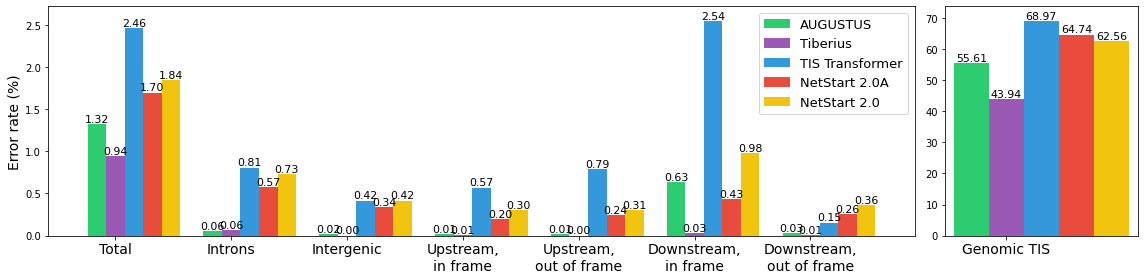

In [59]:
visualize_error_rates(netstart_genomic_overall_df, best_threshold_netstart_overall_genomic, 
                      esm2_finetuned_genomic_df, best_threshold_esm2_finetuned_genomic,
                      TIS_transformer_genomic_df, best_threshold_tis_transformer_genomic,
                      augustus_genomic_df, tiberius_genomic_df,
                      ["homo_sapiens"],
                      "homo_sapiens")


In [60]:
def visualize_error_rates(netstart_df, best_threshold_netstart,
                          esm2_finetuned_df, best_threshold_esm2_finetuned,
                          TIS_transformer_df, best_threshold_TIS_transformer,
                          augustus_df, 
                          species_group, 
                          title):
    
    def __calculate_error_rates__(species_group_df, best_threshold):
        intron_data = species_group_df[species_group_df["seq_type"] == "Intron"]
        intergenic_data = species_group_df[species_group_df["seq_type"] == "Intergenic"]
        up_in_data = species_group_df[species_group_df["seq_type"] == "Upstream, in frame"]
        up_out_data = species_group_df[species_group_df["seq_type"] == "Upstream, out of frame"]
        down_in_data = species_group_df[species_group_df["seq_type"] == "Downstream, in frame"]
        down_out_data = species_group_df[species_group_df["seq_type"] == "Downstream, out of frame"]
        TIS_data = species_group_df[species_group_df["seq_type"] == "Genomic TIS"]


        error_rate_total = round(np.mean(np.array(species_group_df["label"]) != (np.array(species_group_df["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_introns = round(np.mean(np.array(intron_data["label"]) != (np.array(intron_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_intergenic = round(np.mean(np.array(intergenic_data["label"]) != (np.array(intergenic_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_up_in = round(np.mean(np.array(up_in_data["label"]) != (np.array(up_in_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_up_out = round(np.mean(np.array(up_out_data["label"]) != (np.array(up_out_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_down_in = round(np.mean(np.array(down_in_data["label"]) != (np.array(down_in_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_down_out = round(np.mean(np.array(down_out_data["label"]) != (np.array(down_out_data["preds"]) >= best_threshold).astype(int)) * 100, 3)
        error_rate_TIS = round(np.mean(np.array(TIS_data["label"]) != (np.array(TIS_data["preds"]) >= best_threshold).astype(int)) * 100, 3)

        return [error_rate_total, error_rate_introns, error_rate_intergenic, error_rate_up_in, error_rate_up_out, error_rate_down_in, error_rate_down_out], [error_rate_TIS]
    
    # Extract group data for the different models
    netstart_species_group_df = netstart_df[netstart_df["species"].isin(species_group)]
    esm2_finetuned_species_group_df = esm2_finetuned_df[esm2_finetuned_df["species"].isin(species_group)]
    TIS_transformer_species_group_df = TIS_transformer_df[TIS_transformer_df["species"].isin(species_group)]
    augustus_species_group_df = augustus_df[augustus_df["species"].isin(species_group)]

    error_rates_netstart = __calculate_error_rates__(netstart_species_group_df, best_threshold_netstart)
    error_rates_esm2 = __calculate_error_rates__(esm2_finetuned_species_group_df, best_threshold_esm2_finetuned)
    error_rates_tis_transformer = __calculate_error_rates__(TIS_transformer_species_group_df, best_threshold_TIS_transformer)
    error_rates_augustus = __calculate_error_rates__(augustus_species_group_df, 0.5)

    non_tis_error_rates = error_rates_augustus[0] + error_rates_tis_transformer[0] + error_rates_esm2[0] + error_rates_netstart[0] 
    tis_error_rates = error_rates_augustus[1] + error_rates_tis_transformer[1] + error_rates_esm2[1] + error_rates_netstart[1]

    # Find the maximum value
    max_value_non_tis = max(non_tis_error_rates)
    max_value_tis = max(tis_error_rates)

    # Create figure with 2 subplots side by side (non-TIS plot left, TIS plot right)
    fig = plt.figure(figsize=(16, 4))  # Wide figure
    gs = GridSpec(1, 2, width_ratios=[4.5, 1])  # Non-TIS plot (ax1) takes 3 parts, TIS plot (ax2) takes 1 part

    ax1 = fig.add_subplot(gs[0])  # Left plot (non-TIS)
    ax2 = fig.add_subplot(gs[1])  # Right plot (TIS)

    # Set ylim with some padding
    ax1.set_ylim([0, max_value_non_tis * 1.07])  # 7% padding
    ax2.set_ylim([0, max_value_tis * 1.07])  # Same padding for ax2

    # Create non-TIS plot on the first subplot (ax1) and make bars wider
    bar_width = 0.16  # Wider bars for non-TIS plot
    index = np.arange(7)  # Sequence types for non-TIS

    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f', '#9b59b6', '#e67e22', '#1abc9c', '#34495e']

    bar1 = ax1.bar(index, error_rates_augustus[0], bar_width, label='AUGUSTUS', color=colors[0])
    bar2 = ax1.bar(index + 1 * bar_width, error_rates_tis_transformer[0], bar_width, label='TIS Transformer', color=colors[1])
    bar3 = ax1.bar(index + 2 * bar_width, error_rates_esm2[0], bar_width, label='NetStart 2.0A', color=colors[2])
    bar4 = ax1.bar(index + 3 * bar_width, error_rates_netstart[0], bar_width, label='NetStart 2.0', color=colors[3])
    
    #ax1.set_xlabel('Sequence type', fontsize=14)
    ax1.set_ylabel('Error rate (%)', fontsize=14)
    ax1.set_title(f'{title}', fontsize=16)
    ax1.set_xticks(index + bar_width)
    ax1.set_xticklabels(['Total', 'Introns', 'Intergenic', 'Upstream,\nin frame', 'Upstream,\nout of frame', 'Downstream,\nin frame', 
                         'Downstream,\nout of frame'], fontsize=14)
    ax1.legend(fontsize=13)

    # Adding value annotations on top of each bar
    def autolabel(bars, ax):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    '%.2f' % height, ha='center', va='bottom', fontsize=11)

    autolabel(bar1, ax1)
    autolabel(bar2, ax1)
    autolabel(bar3, ax1)
    autolabel(bar4, ax1)
    
    # Create TIS plot on the second subplot (ax2) with narrower bars
    bar_width = 0.10  # Narrower bars for TIS plot
    index = np.arange(1)  # Only one sequence type (TIS)
    
    bar1 = ax2.bar(index, error_rates_augustus[1], bar_width, label='AUGUSTUS', color=colors[0])
    bar2 = ax2.bar(index + 1 * bar_width, error_rates_tis_transformer[1], bar_width, label='TIS Transformer', color=colors[1])
    bar3 = ax2.bar(index + 2 * bar_width, error_rates_esm2[1], bar_width, label='NetStart 2.0A', color=colors[2])
    bar4 = ax2.bar(index + 3 * bar_width, error_rates_netstart[1], bar_width, label='NetStart 2.0', color=colors[3])
    
    #ax2.set_xlabel('Sequence type', fontsize=14)
    #ax2.set_ylabel('Error rate', fontsize=14)
    #ax2.set_title(f'{title} - TIS', fontsize=16)
    ax2.set_xticks(index + bar_width)
    ax2.set_xticklabels(['Genomic TIS'], fontsize=14)
    #ax2.legend(fontsize=13)

    autolabel(bar1, ax2)
    autolabel(bar2, ax2)
    autolabel(bar3, ax2)
    autolabel(bar4, ax2)

    # Show plot
    plt.tight_layout()
    plt.savefig("../../results/evaluation/benchmark_genomic/error_rates_"+title+".png", bbox_inches='tight')
    plt.show()

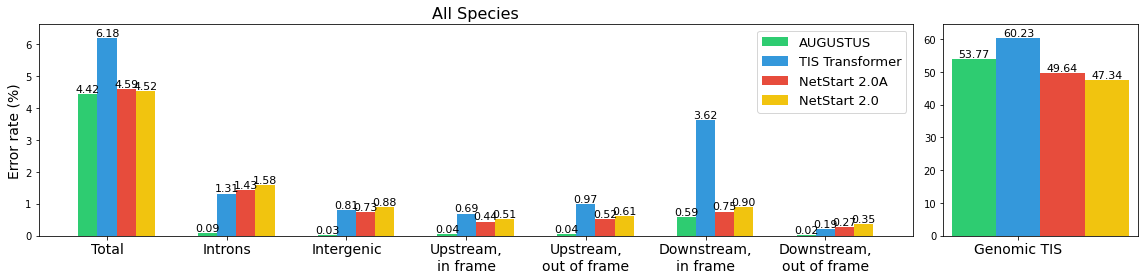

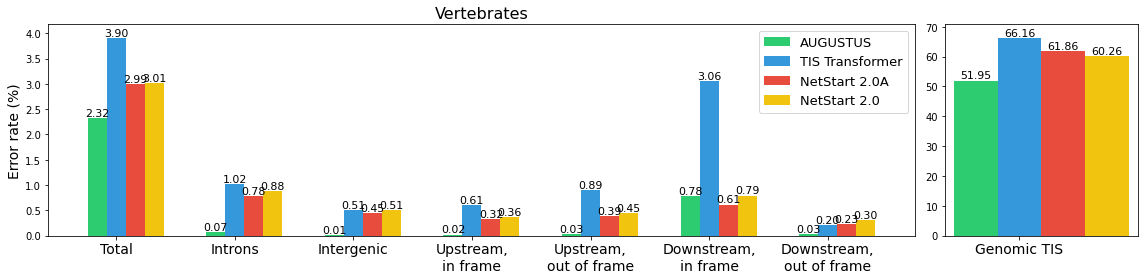

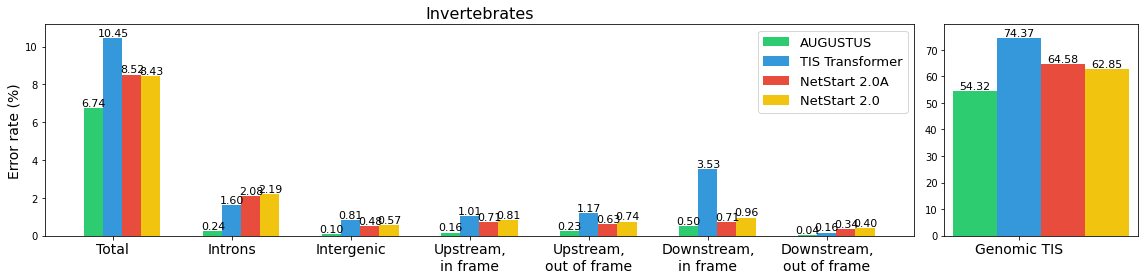

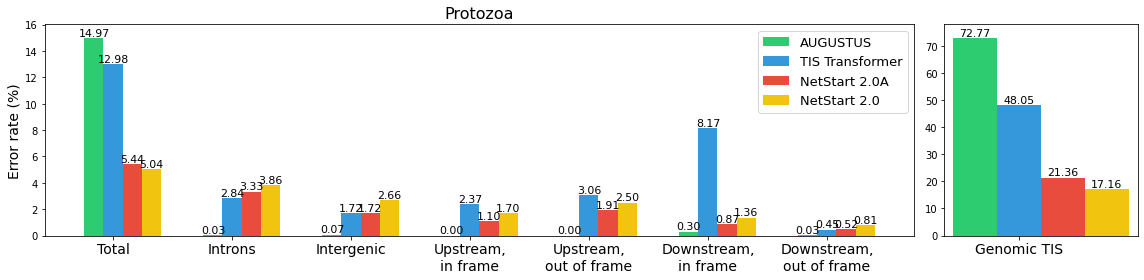

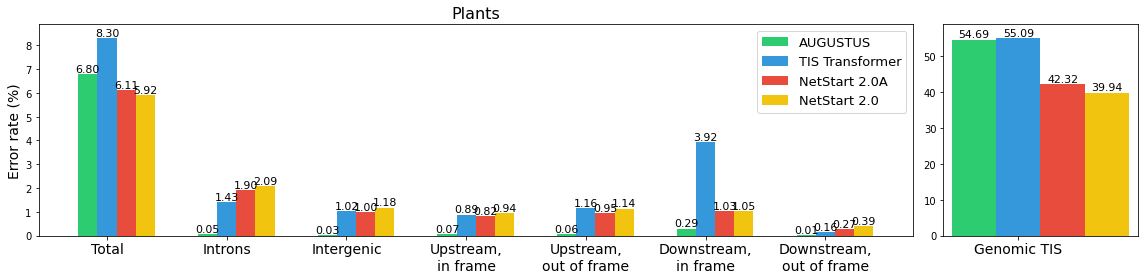

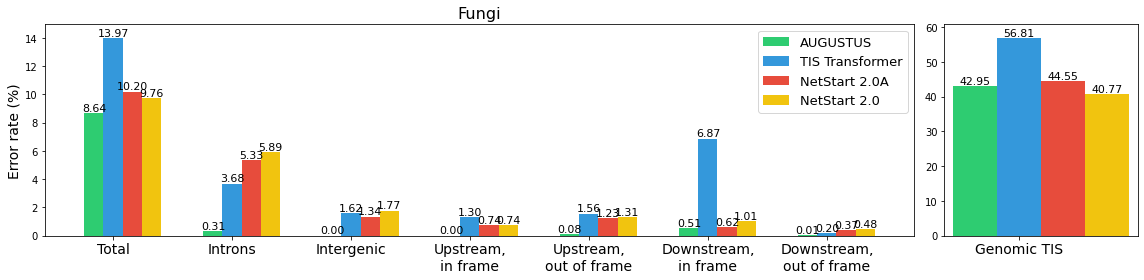

In [61]:
visualize_error_rates(netstart_genomic_overall_df, best_threshold_netstart_overall_genomic, 
                      esm2_finetuned_genomic_df, best_threshold_esm2_finetuned_genomic,
                      TIS_transformer_genomic_df, best_threshold_tis_transformer_genomic,
                      augustus_genomic_df,
                      species_list,
                      "All Species")

visualize_error_rates(netstart_genomic_overall_df, best_threshold_netstart_overall_genomic, 
                      esm2_finetuned_genomic_df, best_threshold_esm2_finetuned_genomic,
                      TIS_transformer_genomic_df, best_threshold_tis_transformer_genomic,
                      augustus_genomic_df,
                      vertebrates_list,
                      "Vertebrates")

visualize_error_rates(netstart_genomic_overall_df, best_threshold_netstart_overall_genomic, 
                      esm2_finetuned_genomic_df, best_threshold_esm2_finetuned_genomic,
                      TIS_transformer_genomic_df, best_threshold_tis_transformer_genomic,
                      augustus_genomic_df,
                      invertebrates_list,
                      "Invertebrates")

visualize_error_rates(netstart_genomic_overall_df, best_threshold_netstart_overall_genomic, 
                      esm2_finetuned_genomic_df, best_threshold_esm2_finetuned_genomic,
                      TIS_transformer_genomic_df, best_threshold_tis_transformer_genomic,
                      augustus_genomic_df,
                      protozoa_list,
                      "Protozoa")

visualize_error_rates(netstart_genomic_overall_df, best_threshold_netstart_overall_genomic, 
                      esm2_finetuned_genomic_df, best_threshold_esm2_finetuned_genomic,
                      TIS_transformer_genomic_df, best_threshold_tis_transformer_genomic,
                      augustus_genomic_df,
                      plants_list,
                      "Plants")

visualize_error_rates(netstart_genomic_overall_df, best_threshold_netstart_overall_genomic, 
                      esm2_finetuned_genomic_df, best_threshold_esm2_finetuned_genomic,
                      TIS_transformer_genomic_df, best_threshold_tis_transformer_genomic,
                      augustus_genomic_df,
                      fungi_list,
                      "Fungi")

/tmp/ipykernel_16017/855645004.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netstart_genomic_tis_overall_df['model'] = 'NetStart 2.0'
/tmp/ipykernel_16017/855645004.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TIS_transformer_genomic_tis_df['model'] = 'TIS Transformer'


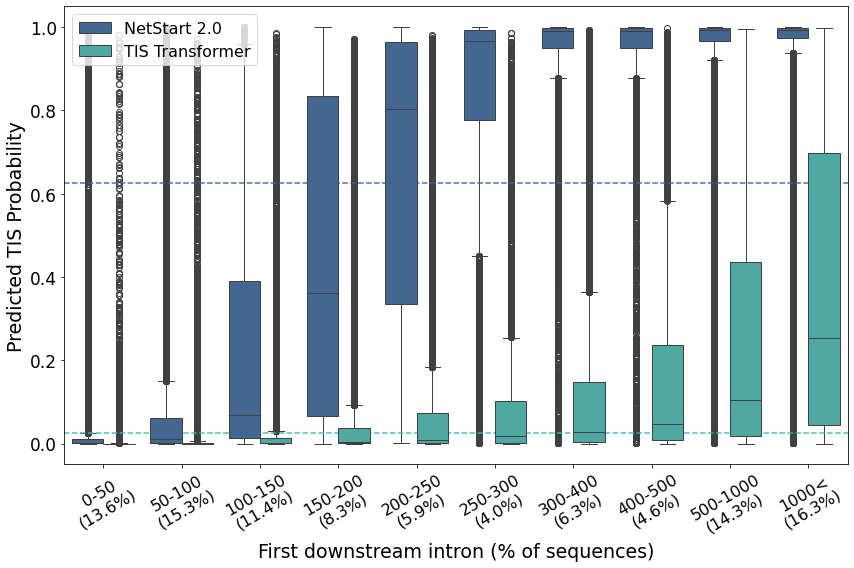

In [62]:
TIS_transformer_genomic_tis_df = TIS_transformer_genomic_df[TIS_transformer_genomic_df["seq_type"] == "Genomic TIS"]
netstart_genomic_tis_overall_df = netstart_genomic_overall_df[netstart_genomic_overall_df["seq_type"] == "Genomic TIS"]

#TIS_transformer_genomic_tis_df = TIS_transformer_genomic_df[(TIS_transformer_genomic_df["seq_type"] == "Genomic TIS") & (TIS_transformer_genomic_df["species"] == "homo_sapiens")]
#netstart_genomic_tis_overall_df = netstart_genomic_overall_df[(netstart_genomic_overall_df["seq_type"] == "Genomic TIS") & (netstart_genomic_overall_df["species"] == "homo_sapiens")]

assert len(TIS_transformer_genomic_tis_df) == len(netstart_genomic_tis_overall_df)

# Calculate correlations (unchanged)
corr_coefficient_netstart = netstart_genomic_overall_df["first_downstream_intron"].corr(netstart_genomic_overall_df["preds"])
spearman_corr_netstart, _ = spearmanr(netstart_genomic_overall_df["first_downstream_intron"], netstart_genomic_overall_df["preds"])
corr_coefficient_tis_transformer = TIS_transformer_genomic_df["first_downstream_intron"].corr(TIS_transformer_genomic_df["preds"])
spearman_corr_tis_transformer, _ = spearmanr(TIS_transformer_genomic_df["first_downstream_intron"], TIS_transformer_genomic_df["preds"])

# Add model columns and combine data
netstart_genomic_tis_overall_df['model'] = 'NetStart 2.0'
TIS_transformer_genomic_tis_df['model'] = 'TIS Transformer'
combined_data = pd.concat([netstart_genomic_tis_overall_df, TIS_transformer_genomic_tis_df])

# Create binned categories
combined_data['binned_intron'] = pd.cut(
    combined_data["first_downstream_intron"],
    bins=[0, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 30000],
    labels=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-400', '400-500', '500-1000', '1000<'],
    include_lowest=True
)

# Calculate percentage of samples in each bin
total_samples = len(netstart_genomic_tis_overall_df)  # Divide by 2 since we have two models
bin_counts = combined_data[combined_data['model'] == 'NetStart 2.0']['binned_intron'].value_counts()
bin_percentages = (bin_counts / total_samples * 100).round(1)

# Calculate percentage of samples in each bin - now with sorting maintained
bin_order = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-400', '400-500', '500-1000', '1000<']
bin_counts = combined_data[combined_data['model'] == 'NetStart 2.0']['binned_intron'].value_counts()
bin_percentages = (bin_counts / total_samples * 100).round(1)
# Reorder according to our bin order
bin_percentages = bin_percentages.reindex(bin_order)

# Create the plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='binned_intron',
    y='preds',
    hue='model',
    data=combined_data,
    palette=[sns.color_palette("mako")[2], sns.color_palette("mako")[4]],
    order=bin_order  # Add this to maintain box order
)

# Add threshold lines
plt.axhline(y=best_threshold_netstart_overall_genomic, color=sns.color_palette("mako")[2], 
            linestyle='--', alpha=0.9)
plt.axhline(y=best_threshold_tis_transformer_genomic, color=sns.color_palette("mako")[4], 
            linestyle='--', alpha=0.9)

# Update x-axis labels to include percentages
plt.xticks(range(len(bin_percentages)), 
           [f'{label}\n({pct}%)' for label, pct in zip(bin_percentages.index, bin_percentages.values)],
           rotation=30, fontsize=16)

plt.yticks(fontsize=17)
plt.xlabel("First downstream intron (% of sequences)", fontsize=19)
plt.ylabel("Predicted TIS Probability", fontsize=19)

# Update legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, fontsize=16, loc="upper left")

plt.tight_layout()
plt.savefig("../../results/evaluation/benchmark_genomic/boxplot_predicted_prob_introns.png", bbox_inches='tight')
plt.show()